# 0. Install and Import dependencies

In [33]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [57]:
# Gym stuff
import os
import yfinance as yf
import itertools
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from finta import TA
from ta.trend import MACD, CCIIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.volume import ChaikinMoneyFlowIndicator
from ta.volatility import KeltnerChannel
from ta.trend import IchimokuIndicator

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

# Processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import quantstats as qs

In [89]:
SEED = 5756

# Specify parameters
stock_name = 'AMD'

# Window size for training
train_window_size = 50
train_start = '2020-01-01'
train_end = '2023-06-01'

test_window_size = 50
learn_iteration = 100000

# Model parameters
model_name = 'DQN'

# Indicator parameters
sma_period = 10

# 1. Get Data

In [90]:
df = yf.Ticker(stock_name)
df = df.history(period="max")
df = df.loc[train_start:, ['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.shape)
df.head()

(1097, 5)


Open       High        Low      Close  \
Date                                                                    
2020-01-02 00:00:00-05:00  46.860001  49.250000  46.630001  49.099998   
2020-01-03 00:00:00-05:00  48.029999  49.389999  47.540001  48.599998   
2020-01-06 00:00:00-05:00  48.020000  48.860001  47.860001  48.389999   
2020-01-07 00:00:00-05:00  49.349998  49.389999  48.040001  48.250000   
2020-01-08 00:00:00-05:00  47.849998  48.299999  47.139999  47.830002   

                             Volume  
Date                                 
2020-01-02 00:00:00-05:00  80331100  
2020-01-03 00:00:00-05:00  73127400  
2020-01-06 00:00:00-05:00  47934900  
2020-01-07 00:00:00-05:00  58061400  
2020-01-08 00:00:00-05:00  53767000

In [91]:
TRAIN_ENV_FRAME_BOUND = (train_window_size, df[train_start:train_end].shape[0])
TEST_ENV_FRAME_BOUND = (df[train_start:train_end].shape[0] + test_window_size, df.shape[0])

In [92]:
TRAIN_ENV_FRAME_BOUND

(50, 860)

In [93]:
TEST_ENV_FRAME_BOUND

(910, 1097)

# 2.1 Add Custom Indicators

## 2.1.3. Calculate SMA, RSI and OBV

In [94]:
df['SMA'] = TA.SMA(df, sma_period)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.1.4. Create New Environments

In [95]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [96]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

# 3. Build Environment and Train

In [97]:
env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=train_window_size)
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [98]:
from sb3_contrib import RecurrentPPO

if model_name == 'A2C':
    model = A2C('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'RecurrentPPO':
    model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'PPO':
    model = PPO('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'DQN':
    model = DQN('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)

# 4. Evaluation

In [99]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=test_window_size)
observation, info = env.reset()
while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 39.98002624511719, 'total_profit': 0.8798260593796677, 'position': <Positions.Short: 0>}


In [100]:
total_profit = round(info['total_profit'], 2)

# Report output
trade_strategy_output = f".\\reports_train2020-2023_test2023-present\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{train_window_size}_ITER{learn_iteration}_trade_strategy.png"
report_output = f".\\reports_train2020-2023_test2023-present\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{train_window_size}_ITER{learn_iteration}_reports.html"

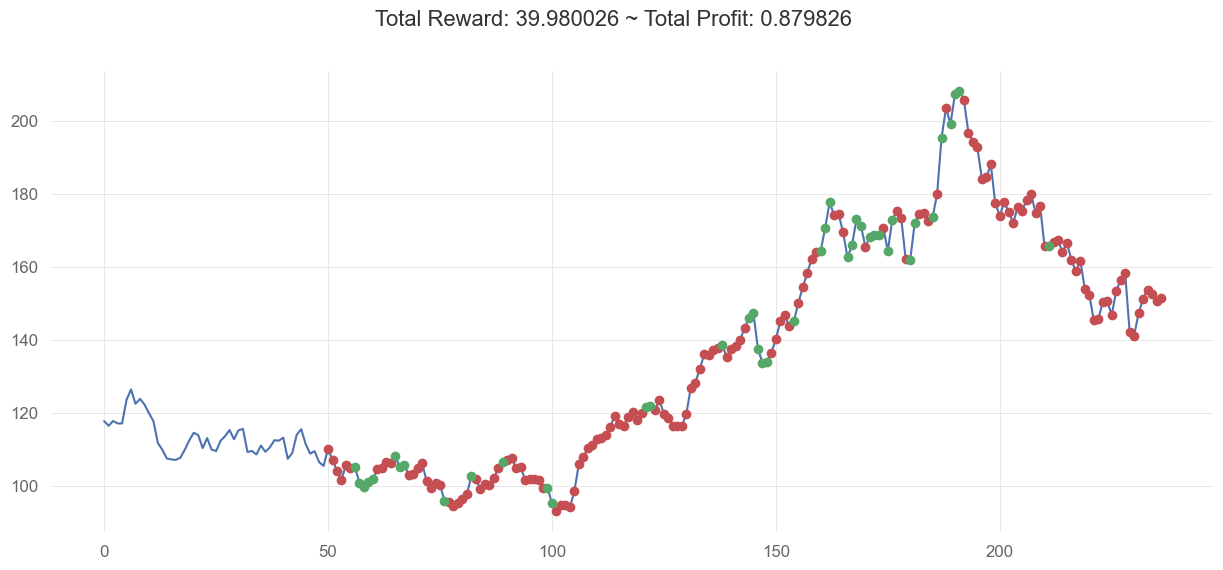

In [101]:
# desc = f'STOCK_NAME: {stock_name}\nTRAIN_WINDOW_SIZE: {train_window_size}\nTRAIN_START: {train_start}\nTRAIN_END: {train_end}\nTEST_WINDOW_SIZE: {test_window_size}\nLEARN_ITERATIONS: {learn_iteration}\nSMA_PERIOD: {sma_period}'

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
# plt.text(0, env.prices.max() - 5, desc)
plt.savefig(trade_strategy_output)
plt.show()

# 5. QuantStats

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

                           Strategy
-------------------------  ----------
Start Period               2023-08-17
End Period                 2024-05-10
Risk-Free Rate             0.0%
Time in Market             11.0%

Cumulative Return          -12.02%
CAGR﹪                     -11.38%

Sharpe                     -0.77
Prob. Sharpe Ratio         24.71%
Smart Sharpe               -0.76
Sortino                    -0.95
Smart Sortino              -0.95
Sortino/√2                 -0.67
Smart Sortino/√2           -0.67
Omega                      0.68

Max Drawdown               -30.06%
Longest DD Days            255
Volatility (ann.)          20.09%
Calmar                     -0.38
Skew                       -1.98
Kurtosis                   22.62

Expected Daily %           -0.07%
Expected Monthly %         -1.27%
Expected Yearly %          -6.2%
Kelly Criterion            -19.61%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.14%
Expected Shortfall (cVaR)  -2.14%

Max Consecut

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2023-08-30  2024-01-05  2024-05-10   255    -30.061472        -28.740939

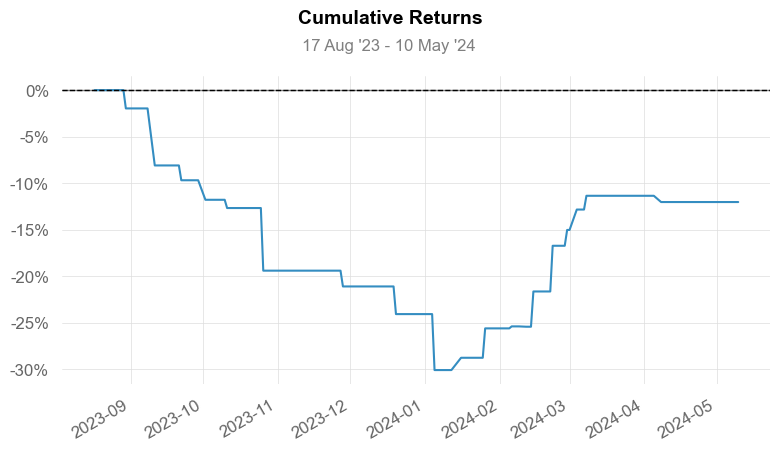

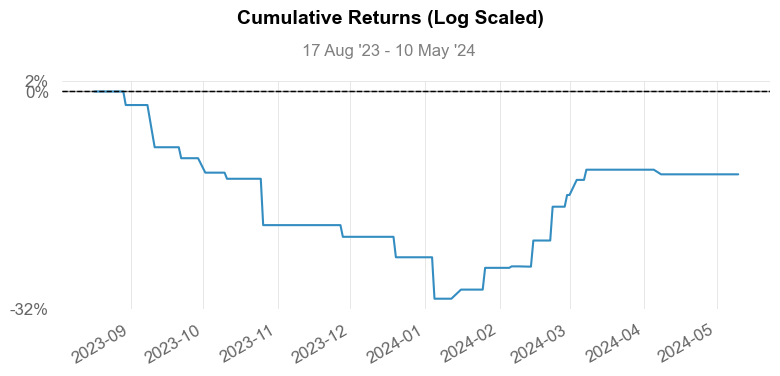

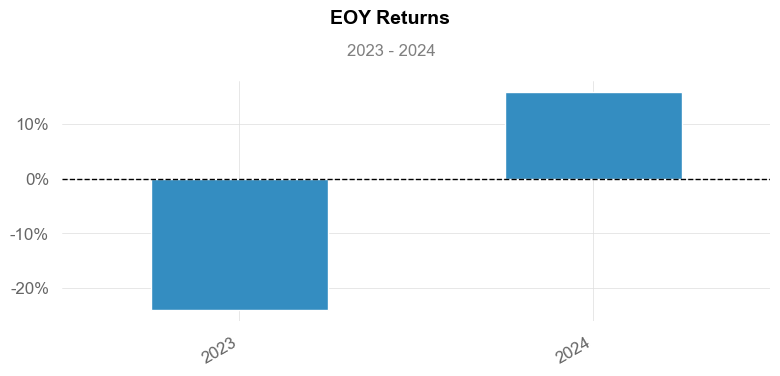

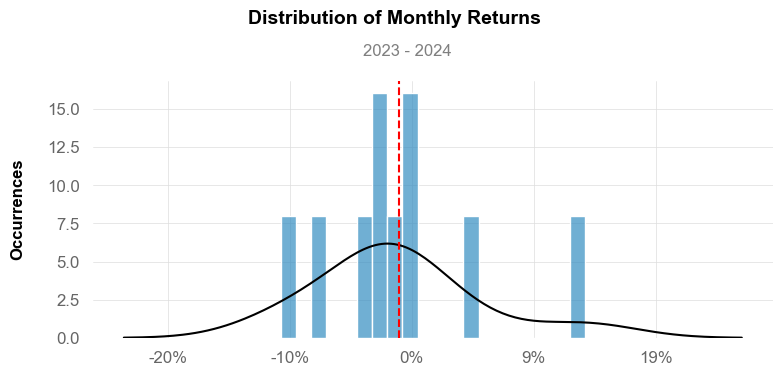

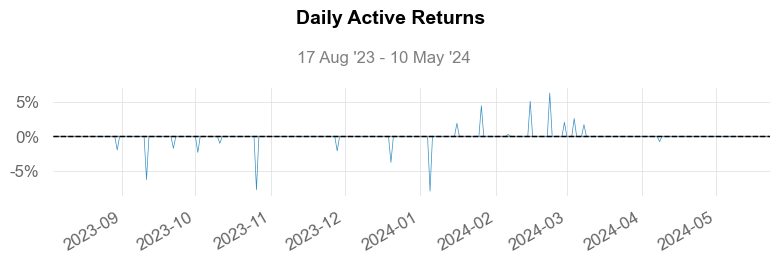

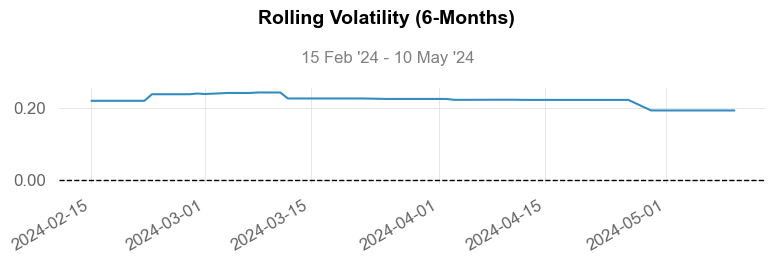

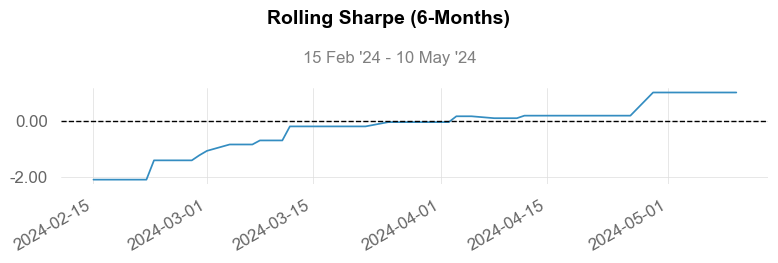

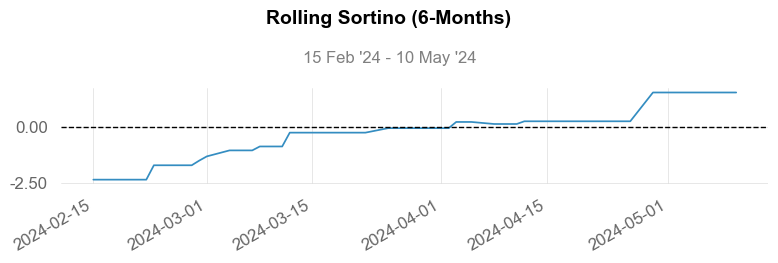

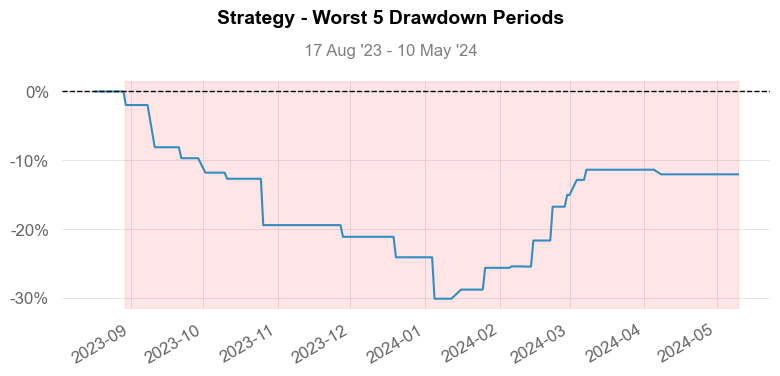

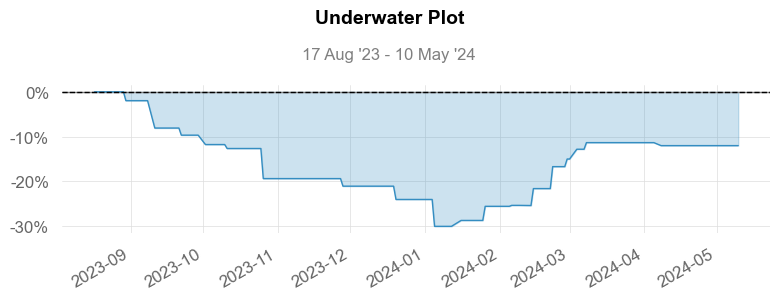

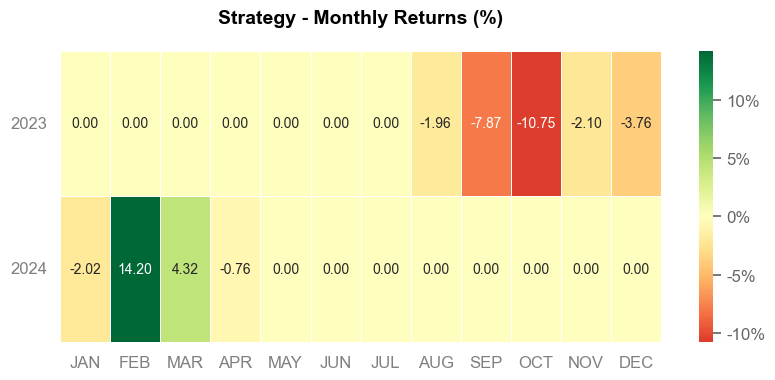

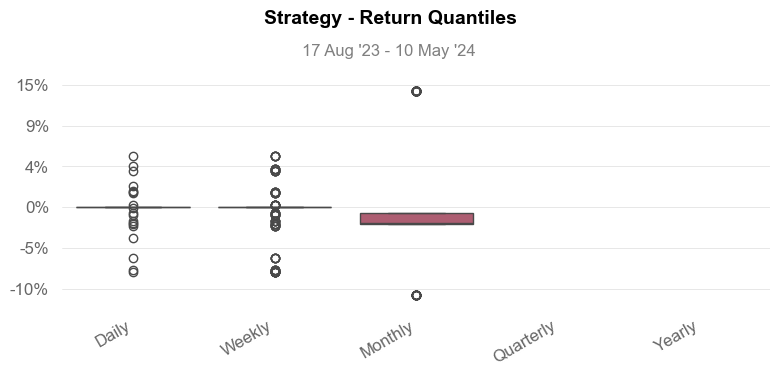

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

In [102]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output=report_output)

In [106]:
from typing import List
SEED = 5756
def analyze_stock(
    stock_name: str,
    window_size: int,
    train_start: str,
    train_end: str,
    learn_iteration: int,
    model_name: str,
    add_all: bool
) -> None:
    SEED = 5756
    df = yf.Ticker(stock_name)
    df = df.history(period="max")
    df = df.loc[train_start:, ['Open', 'High', 'Low', 'Close', 'Volume']]
    TRAIN_ENV_FRAME_BOUND = (window_size, df[train_start:train_end].shape[0])
    TEST_ENV_FRAME_BOUND = (df[train_start:train_end].shape[0] + window_size, df.shape[0])

    def add_all_features(df, add_all=True):
        if add_all:
            df['SMA'] = TA.SMA(df, period=10)  # Make sure SMA_PERIOD is defined

            # Add EMA
            df['EMA'] = TA.EMA(df, period=20)  # You can adjust the period as needed

            # Add RSI (you already have this)
            rsi = RSIIndicator(close=df['Close'])
            df['RSI'] = rsi.rsi()

            # Add MACD
            macd = MACD(close=df['Close'])
            df['MACD'] = macd.macd()

            # Add Bollinger Bands
            bollinger_bands = BollingerBands(close=df['Close'])
            df['BB_UPPER'] = bollinger_bands.bollinger_hband()
            df['BB_LOWER'] = bollinger_bands.bollinger_lband()
            df['BB_MIDDLE'] = bollinger_bands.bollinger_mavg()

            # Add Stochastic Oscillator
            # stoch = TA.STOCH(df)
            # df['STOCH_K'] = stoch['%K']
            # df['STOCH_D'] = stoch['%D']

            # Add Average True Range
            df['ATR'] = TA.ATR(df)

            # Add OBV (you already have this)
            df['OBV'] = TA.OBV(df)

            # Add Commodity Channel Index (CCI)
            cci = CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20)
            df['CCI'] = cci.cci()

            # Add Rate of Change (ROC)
            df['ROC'] = TA.ROC(df, period=10)  # Default window is 10, adjust as needed

            # Add Chaikin Money Flow (CMF)
            cmf = ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=20)
            df['CMF'] = cmf.chaikin_money_flow()

            # Add Force Index
            df['Force_Index'] = (df['Close'].diff(1) * df['Volume']).fillna(0)

            # Add Keltner Channel
            keltner = TA.KC(df, period=20)  # Default window is 20, adjust as needed
            kc = KeltnerChannel(high=df['High'], low=df['Low'], close=df['Close'], window=20)
            # Add Keltner Channel values to DataFrame
            df['KC_UPPER'] = kc.keltner_channel_hband()
            df['KC_LOWER'] = kc.keltner_channel_lband()
            df['KC_MIDDLE'] = kc.keltner_channel_mband() 

            # Add Parabolic SAR
            # df['SAR'] = TA.SAR(df)  # Parameters can be adjusted for sensitivity

            # Add Ichimoku Cloud
            ichimoku = TA.ICHIMOKU(df)  # The window sizes can be adjusted if necessary
            from ta.trend import IchimokuIndicator

            # Add Ichimoku Indicator
            from ta.trend import IchimokuIndicator

            # Initialize Ichimoku Indicator using the 'High' and 'Low' columns of your DataFrame
            ichimoku_indicator = IchimokuIndicator(
                high=df['High'], 
                low=df['Low'], 
                window1=9, 
                window2=26, 
                window3=52,
                visual=False,  # If True, shift window2 (n2) period forward for visualization purposes
                fillna=False   # Set to True if you want to fill NA values
            )

            # Access the Ichimoku Cloud components
            df['ICHIMOKU_A'] = ichimoku_indicator.ichimoku_a()
            df['ICHIMOKU_B'] = ichimoku_indicator.ichimoku_b()
            df['ICHIMOKU_BASE_LINE'] = ichimoku_indicator.ichimoku_base_line()
            df['ICHIMOKU_CONVERSION_LINE'] = ichimoku_indicator.ichimoku_conversion_line()

            # Handle NaN values for newly added indicators
            df.fillna(0, inplace=True)

        return df

    df_augmented = add_all_features(df.copy(), add_all=add_all)

    def add_signals(env):
        start = env.frame_bound[0] - env.window_size
        end = env.frame_bound[1]
        prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
        signal_features = env.df.loc[:, :].to_numpy()[start:end]
        return prices, signal_features
    
    class MyCustomEnv(StocksEnv):
        _process_data = add_signals

    env2 = MyCustomEnv(df=df_augmented, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=window_size)
    env_maker = lambda: env2
    env = DummyVecEnv([env_maker])

    if model_name == 'A2C':
        model = A2C('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'RecurrentPPO':
        model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'PPO':
        model = PPO('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'DQN':
        model = DQN('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)

    env = MyCustomEnv(df=df_augmented, frame_bound=TEST_ENV_FRAME_BOUND, window_size=window_size)
    observation, info = env.reset()
    while True: 
        observation = observation[np.newaxis, ...]
        action, _states = model.predict(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            print("info", info)
            break
    
    total_profit = round(info['total_profit'], 2)

    # Report output
    trade_strategy_output = f".\\{stock_name}\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{window_size}_ITER{learn_iteration}_FEAT{add_all}_trade_strategy.png"
    report_output = f".\\{stock_name}\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{window_size}_ITER{learn_iteration}_FEAT{add_all}_reports.html"

    desc = f'STOCK_NAME: {stock_name}\nwindow_size: {window_size}\nTRAIN_START: {train_start}\nTRAIN_END: {train_end}\nwindow_size: {window_size}\nLEARN_ITERATIONS: {learn_iteration}\nSMA_PERIOD: 10'
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.text(0, env.prices.max() - 5, desc)
    plt.savefig(trade_strategy_output)

    qs.extend_pandas()

    net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df_augmented.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
    returns = net_worth.pct_change().iloc[1:]

    qs.reports.html(returns, output=report_output)

    analysis = {
        'stock_name': stock_name,
        'window_size': window_size,
        'train_start': train_start,
        'train_end': train_end,
        'learn_iteration': learn_iteration,
        'model_name': model_name,
        'add_all': add_all,
        'total_profit': total_profit
    }
    return analysis

info {'total_reward': 7.040016174316406, 'total_profit': 0.4544551416577526, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': -18.909950256347656, 'total_profit': 0.3587486226945369, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 18.3499755859375, 'total_profit': 0.5115108962655001, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 29.709999084472656, 'total_profit': 0.5112508456465543, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 10.140029907226562, 'total_profit': 0.7668087973666593, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': -39.22998809814453, 'total_profit': 0.3481115538971504, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': -12.139976501464844, 'total_profit': 0.39962928393378255, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 80.76998901367188, 'total_profit': 0.6850886539633185, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': -12.139976501464844, 'total_profit': 0.39962928393378255, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 80.76998901367188, 'total_profit': 0.6850886539633185, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': -9.349952697753906, 'total_profit': 0.4185333059487361, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': -2.1899948120117188, 'total_profit': 0.45795634648201955, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 6.519996643066406, 'total_profit': 0.9731271916424487, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 18.579978942871094, 'total_profit': 0.717437752832393, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 3.9000701904296875, 'total_profit': 0.4705327773801862, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 40.410064697265625, 'total_profit': 0.5514474553555927, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 26.6500244140625, 'total_profit': 0.5958364991524121, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 10.850013732910156, 'total_profit': 0.6495252488262906, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 14.700019836425781, 'total_profit': 0.5884386311219524, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 1.9899520874023438, 'total_profit': 0.4421378027220892, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 13.790008544921875, 'total_profit': 0.5488032106376651, 'position': <Positions.Long: 1>}


C:\Users\supha\AppData\Local\Temp\ipykernel_9772\3016530115.py:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,6))
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over bo

info {'total_reward': -2.7600326538085938, 'total_profit': 0.5038186357610283, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 11.869941711425781, 'total_profit': 0.5300502550998382, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 54.75996398925781, 'total_profit': 0.6569509291755735, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 18.029998779296875, 'total_profit': 0.4949374785029419, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 9.850028991699219, 'total_profit': 0.5129208680816824, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 18.029998779296875, 'total_profit': 0.4949374785029419, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 9.850028991699219, 'total_profit': 0.5129208680816824, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 19.510009765625, 'total_profit': 0.5743911905657245, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 33.08995056152344, 'total_profit': 0.6273889217024435, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 35.48003387451172, 'total_profit': 0.5672089756944987, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': -0.3600006103515625, 'total_profit': 0.7514472129354703, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 54.78997802734375, 'total_profit': 0.697236925371637, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 20.510032653808594, 'total_profit': 0.5892807360378294, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 50.39002227783203, 'total_profit': 0.779912652370201, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 51.27003479003906, 'total_profit': 0.8051734495705776, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': -5.629974365234375, 'total_profit': 0.5314184363048938, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 66.08003997802734, 'total_profit': 0.8365904537291062, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 71.24994659423828, 'total_profit': 0.838136476719871, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 23.159996032714844, 'total_profit': 0.6157133893417671, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 3.9899749755859375, 'total_profit': 0.6114763181956876, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 31.699974060058594, 'total_profit': 0.7161281441204433, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 26.149986267089844, 'total_profit': 0.740226070162668, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 1.2799911499023438, 'total_profit': 0.5264046792609773, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 26.149986267089844, 'total_profit': 0.740226070162668, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 1.2799911499023438, 'total_profit': 0.5264046792609773, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 14.840011596679688, 'total_profit': 0.5963413662427319, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 21.28998565673828, 'total_profit': 0.6099783234256857, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': -54.12999725341797, 'total_profit': 0.3675377556342879, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 50.98998260498047, 'total_profit': 0.9212117241462029, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': -1.9600143432617188, 'total_profit': 0.7092606937945284, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 68.47998046875, 'total_profit': 0.9582659025396623, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 24.090011596679688, 'total_profit': 0.6633846359773301, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

info {'total_reward': 85.66997528076172, 'total_profit': 1.0038412419167715, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

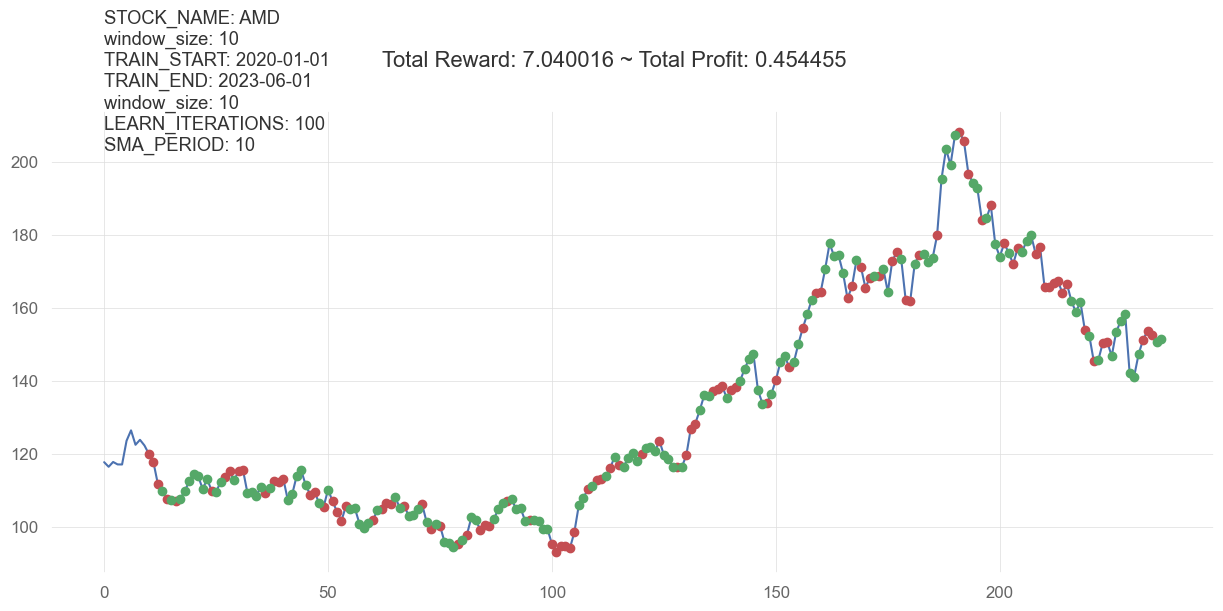

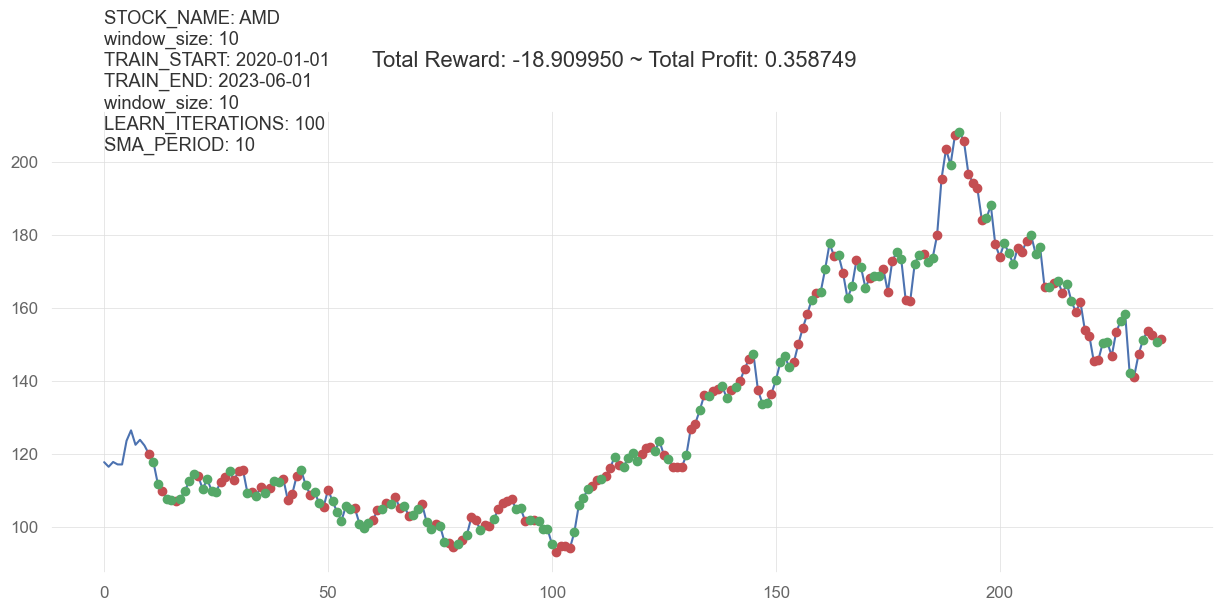

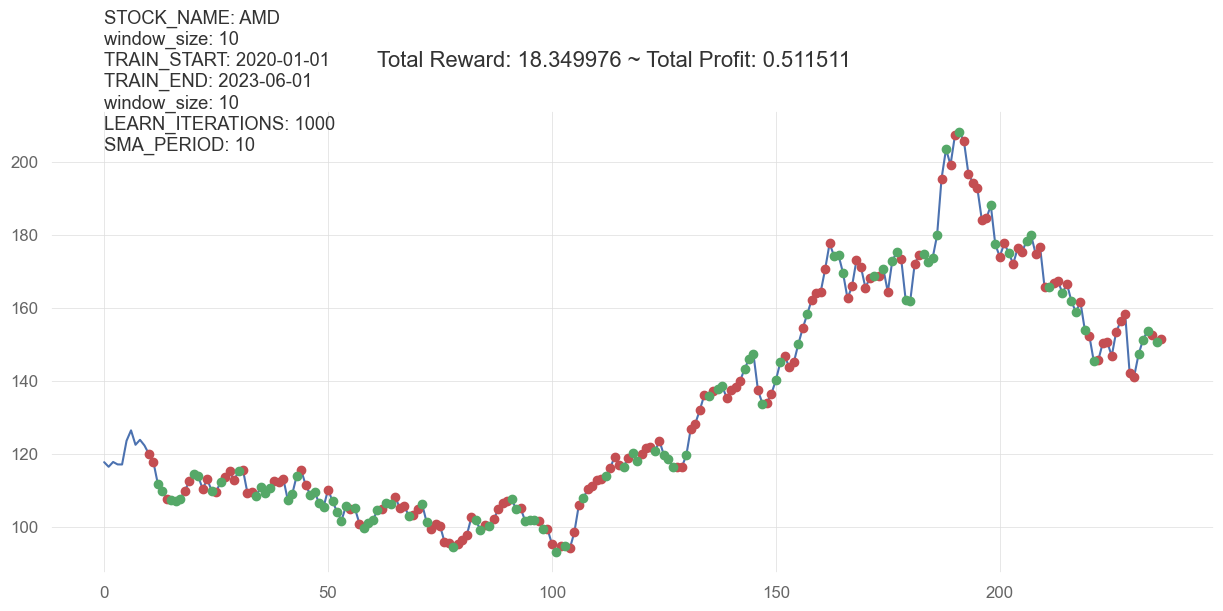

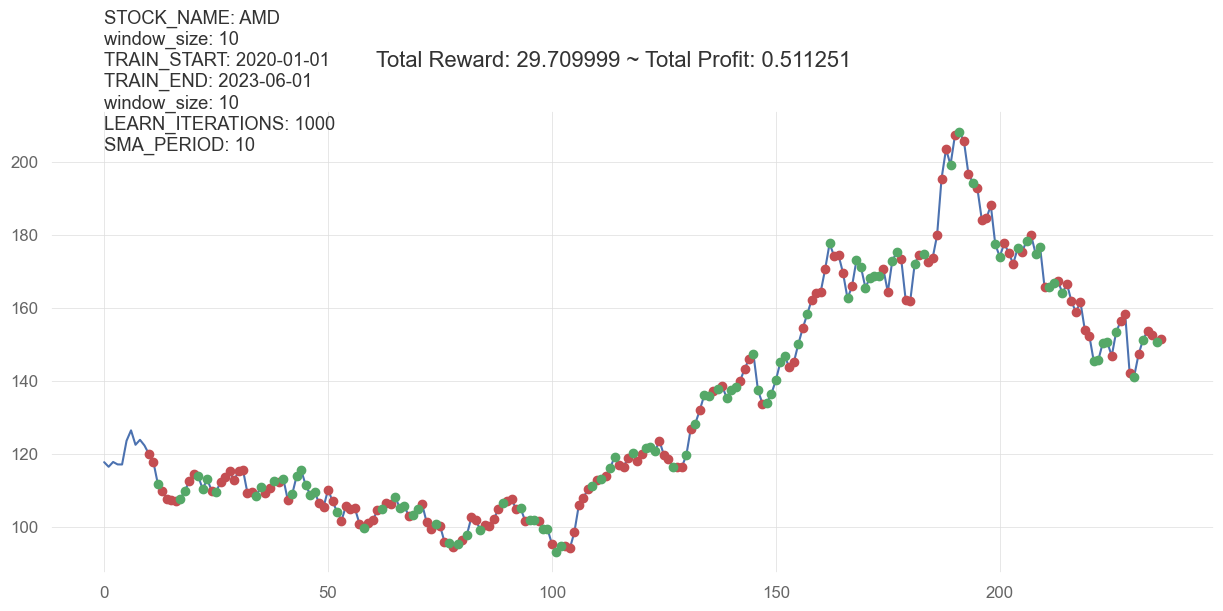

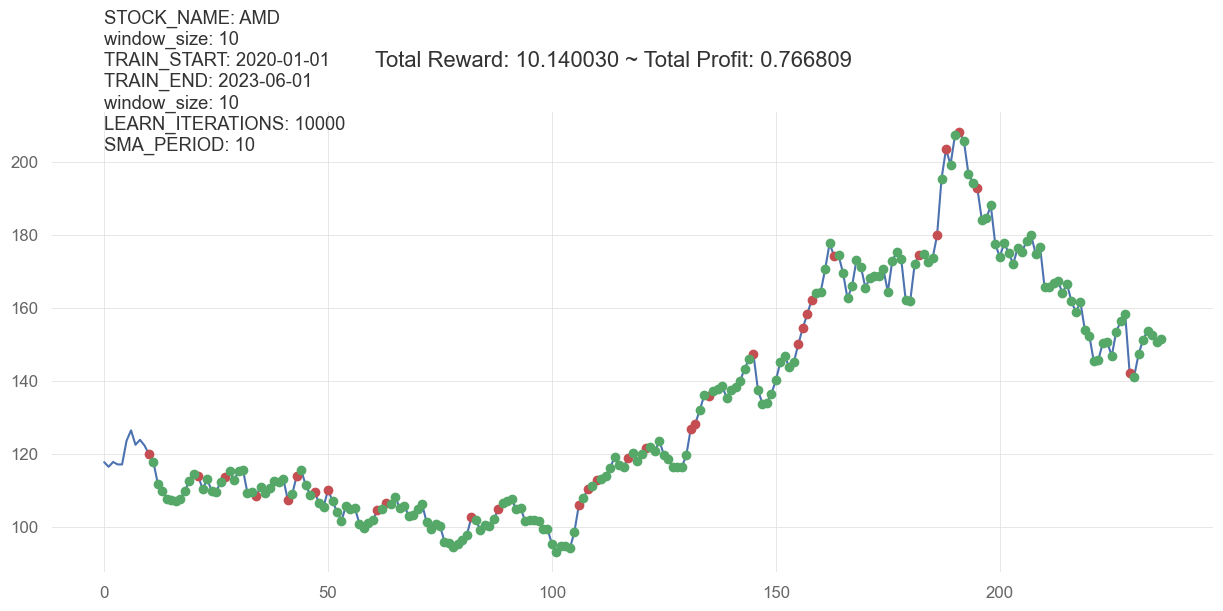

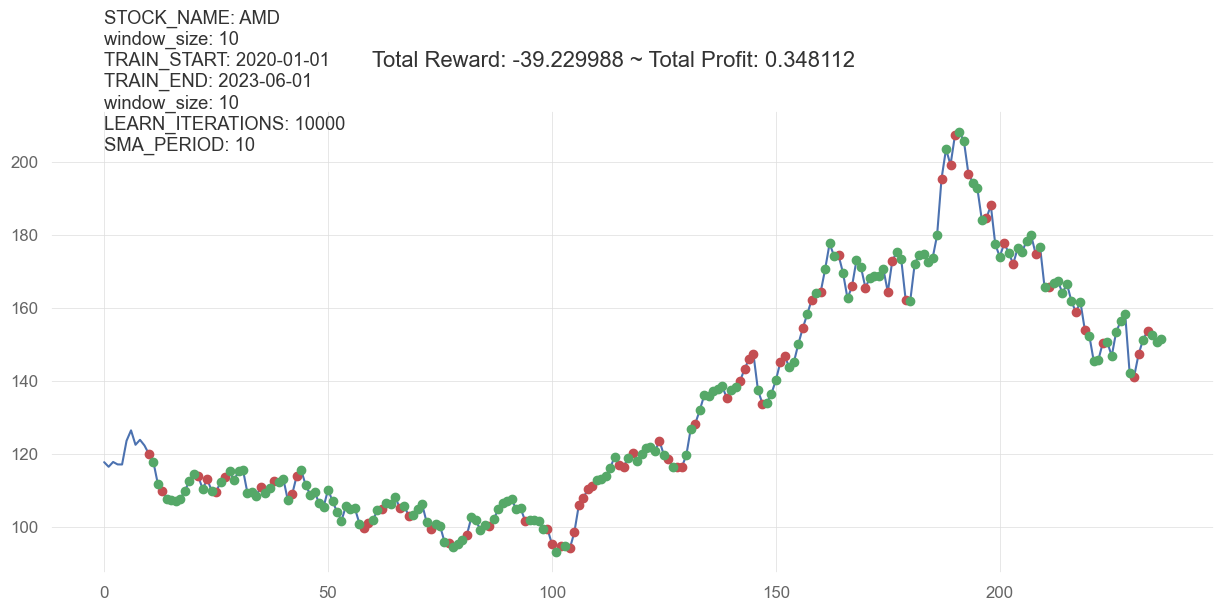

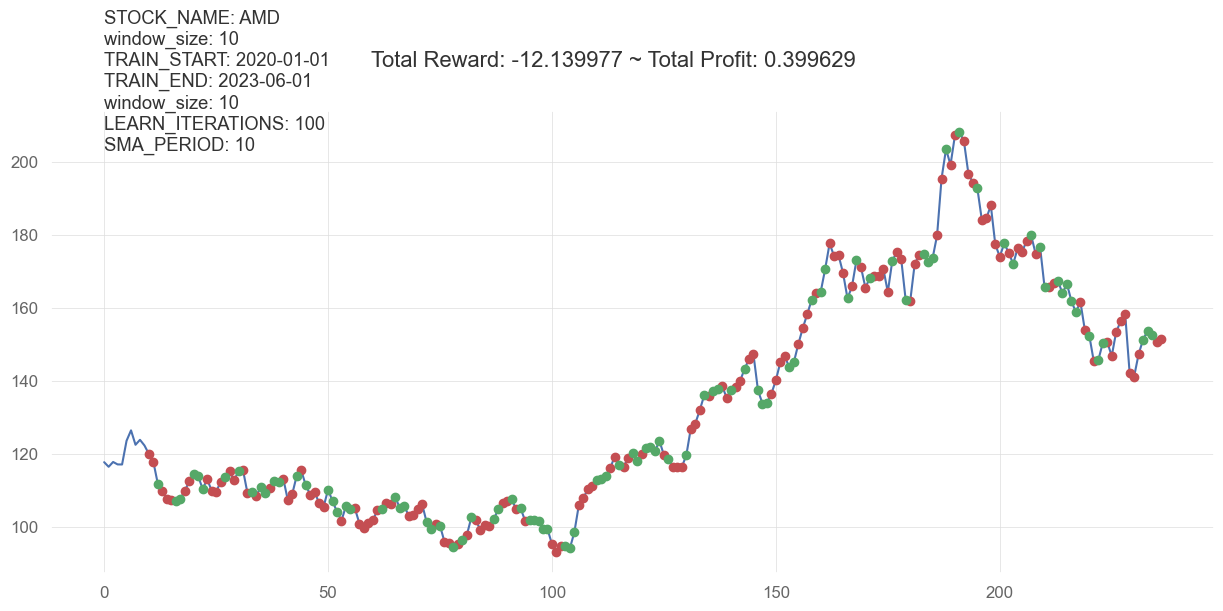

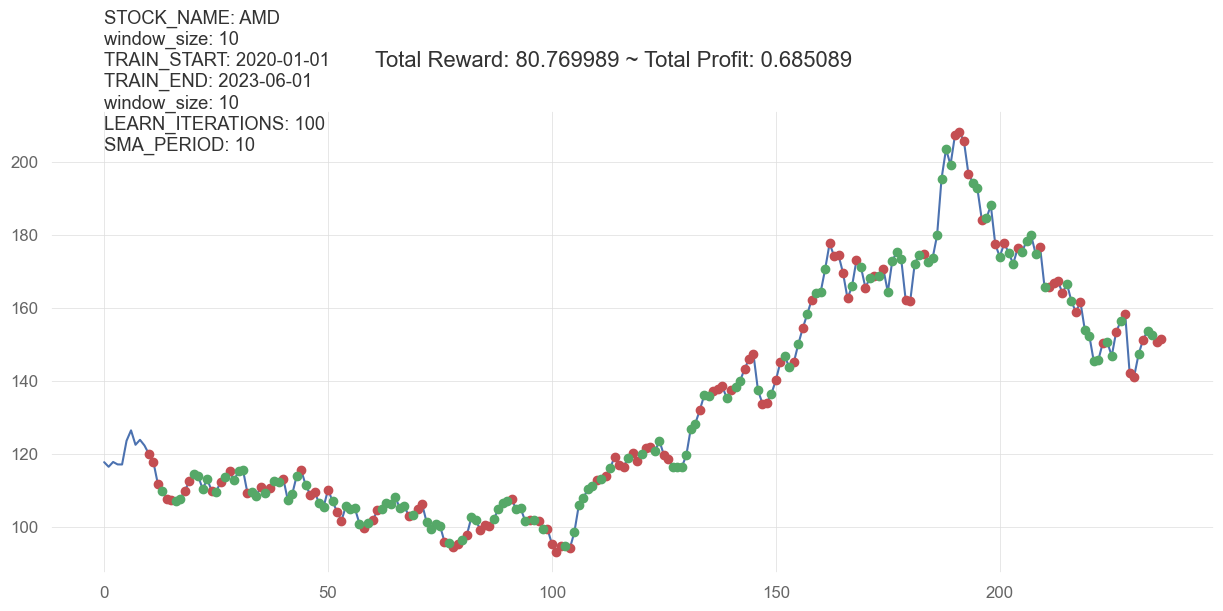

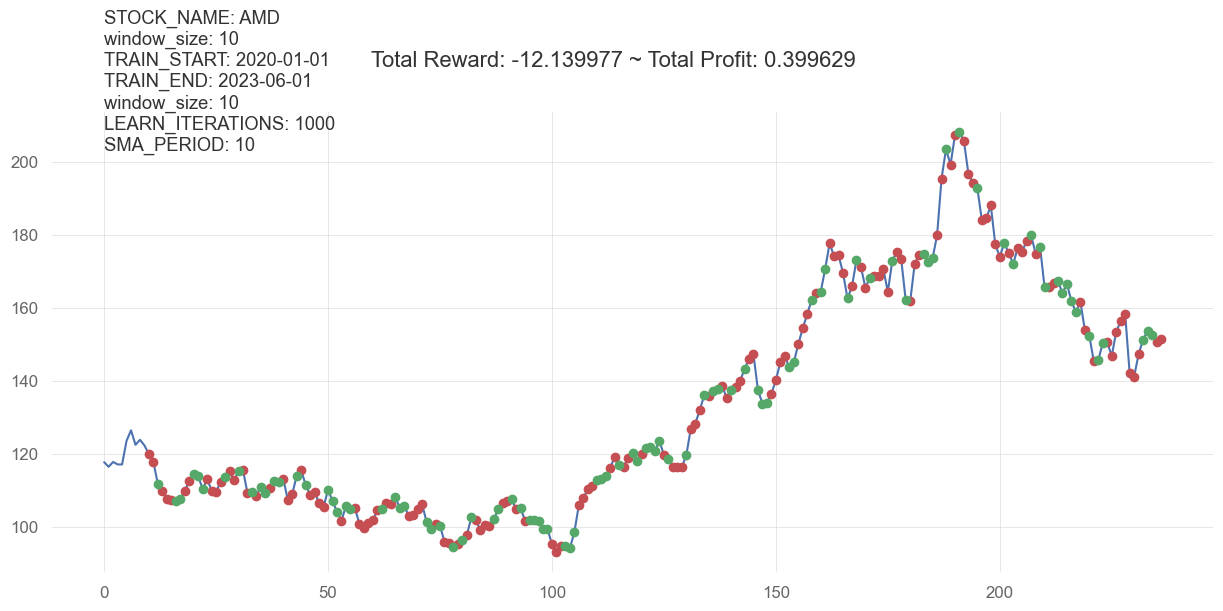

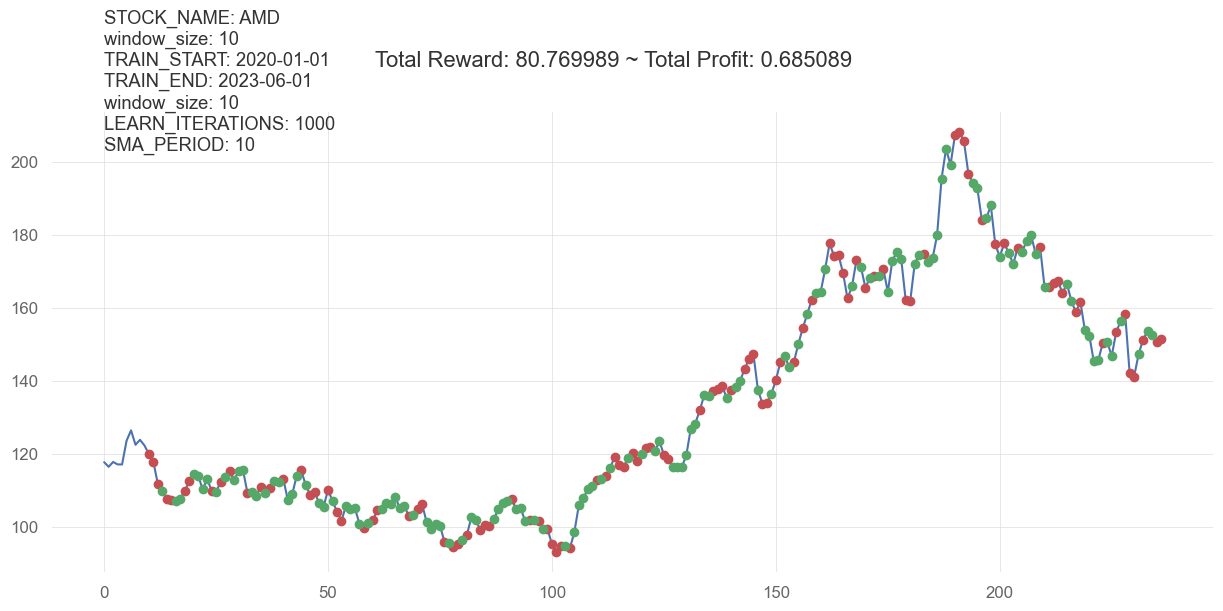

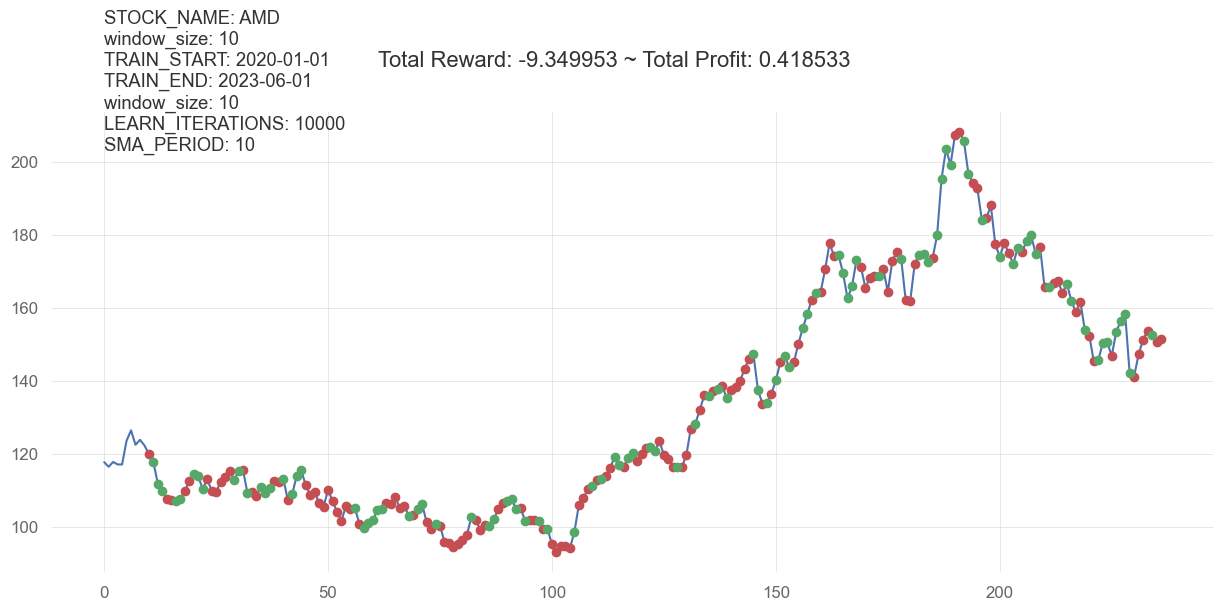

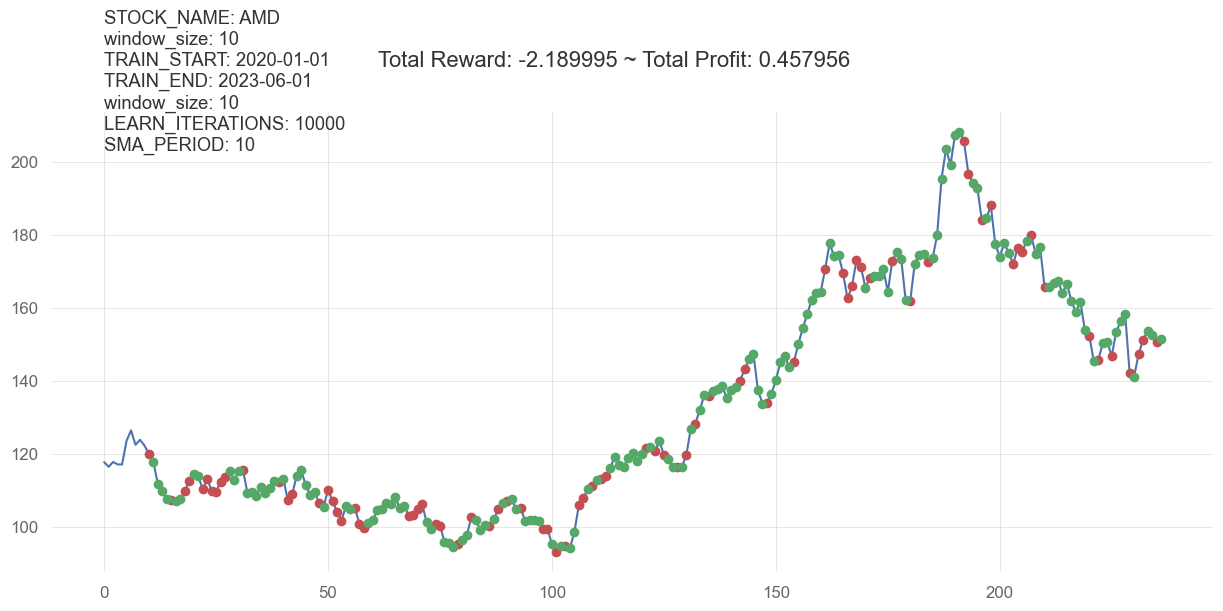

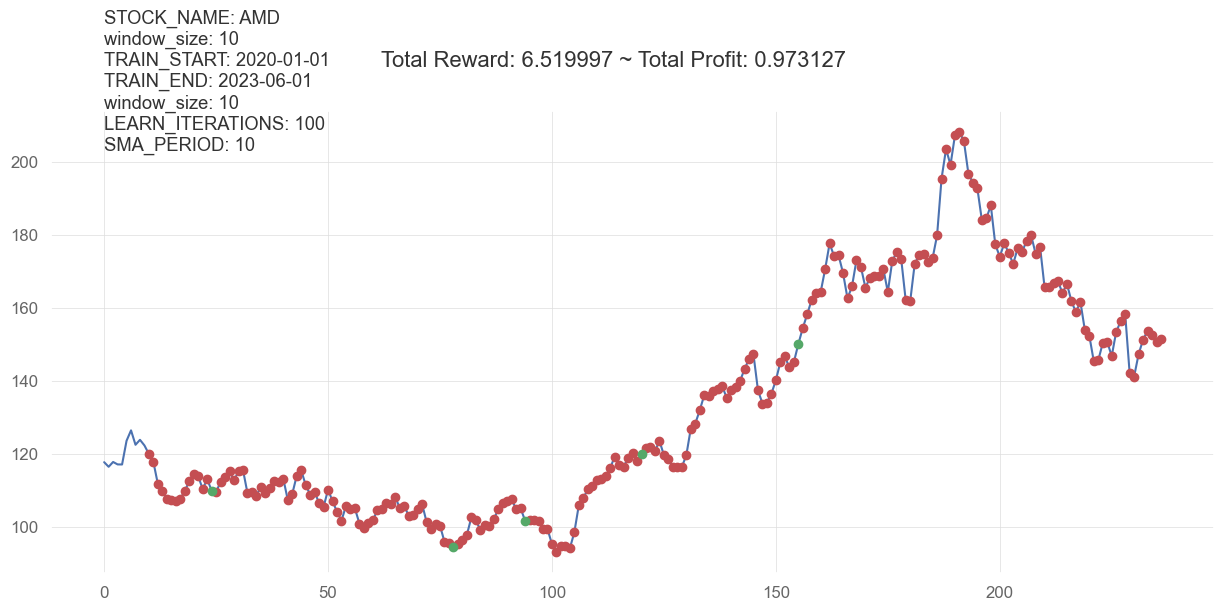

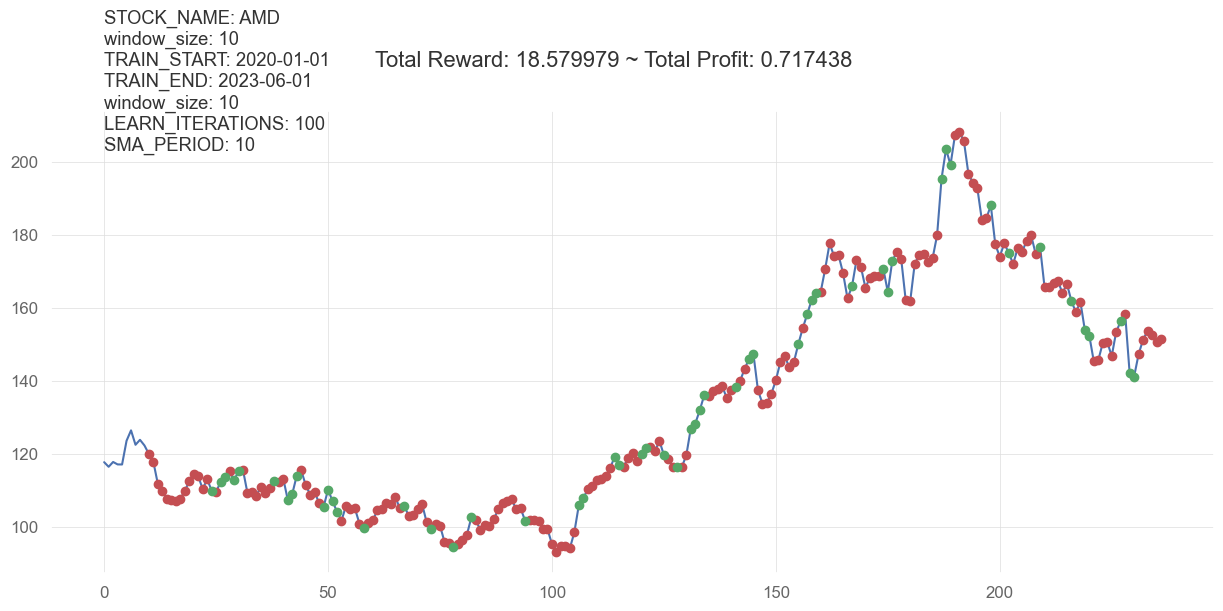

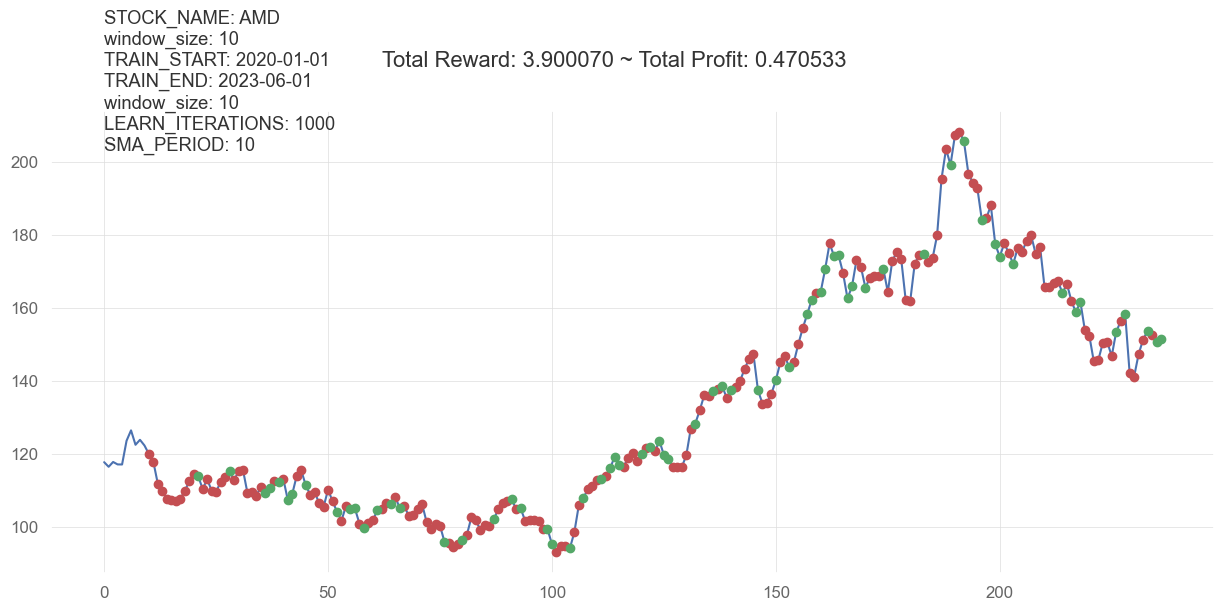

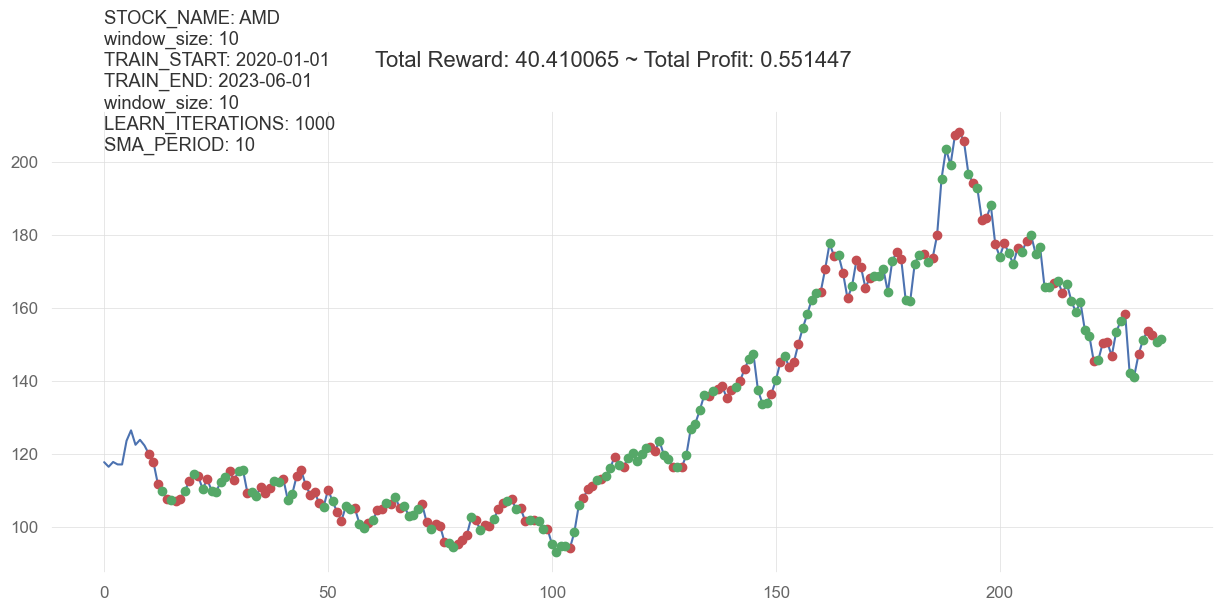

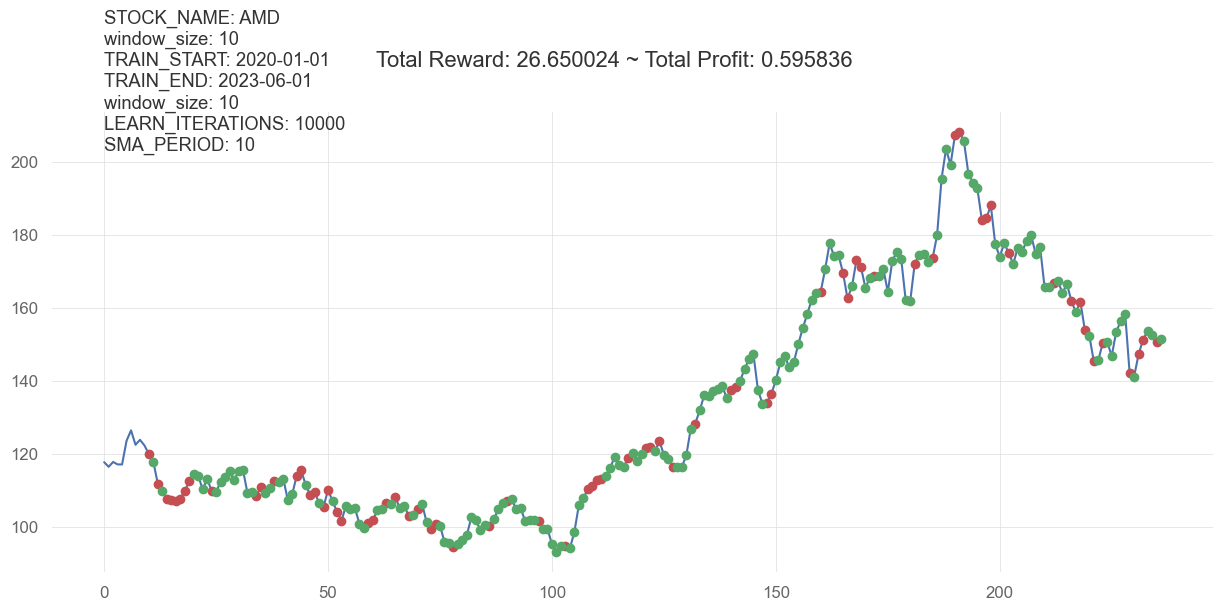

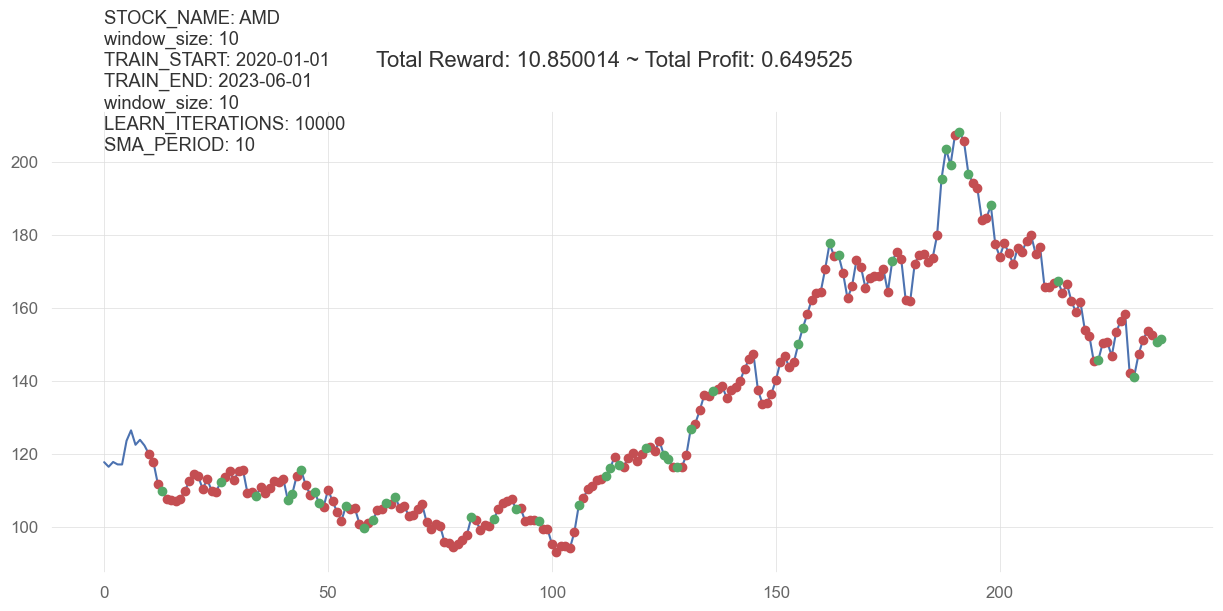

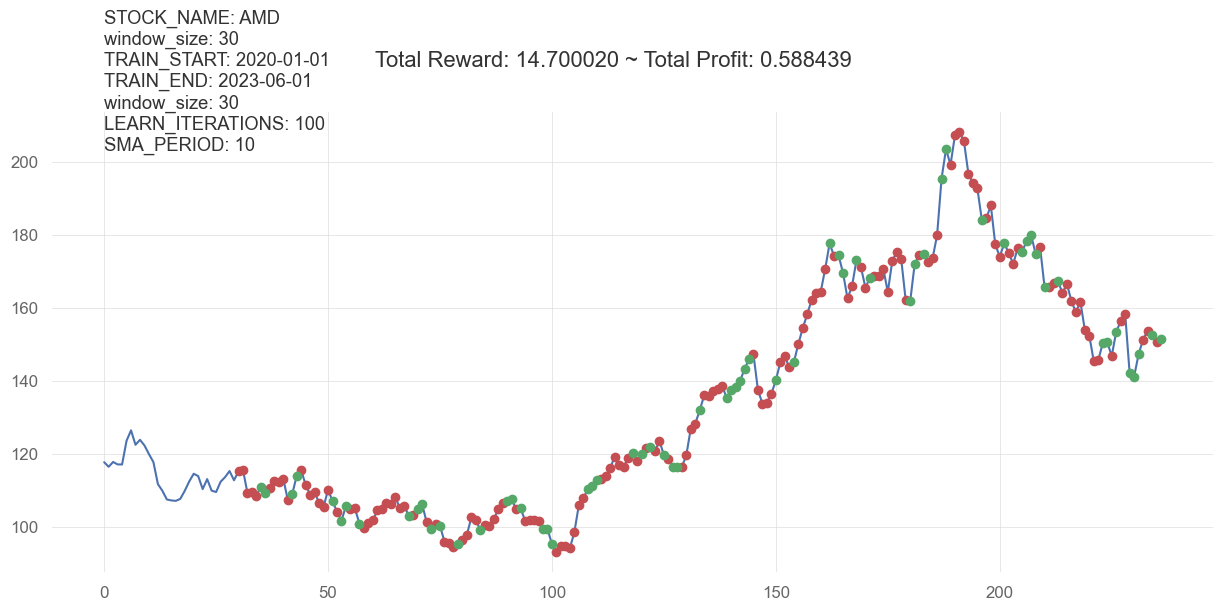

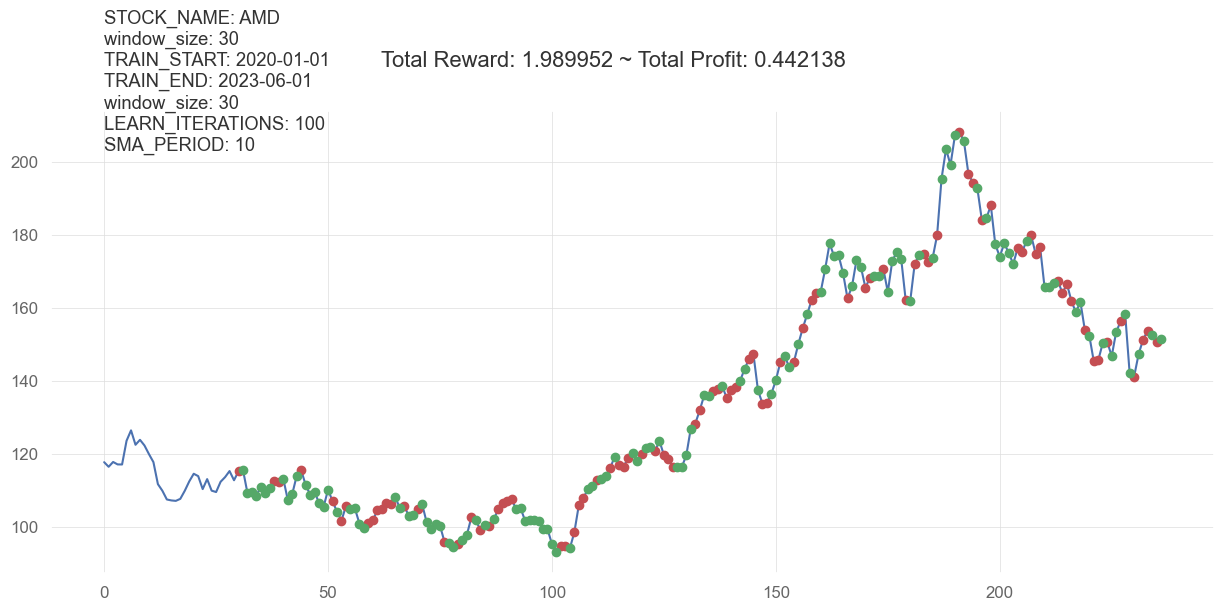

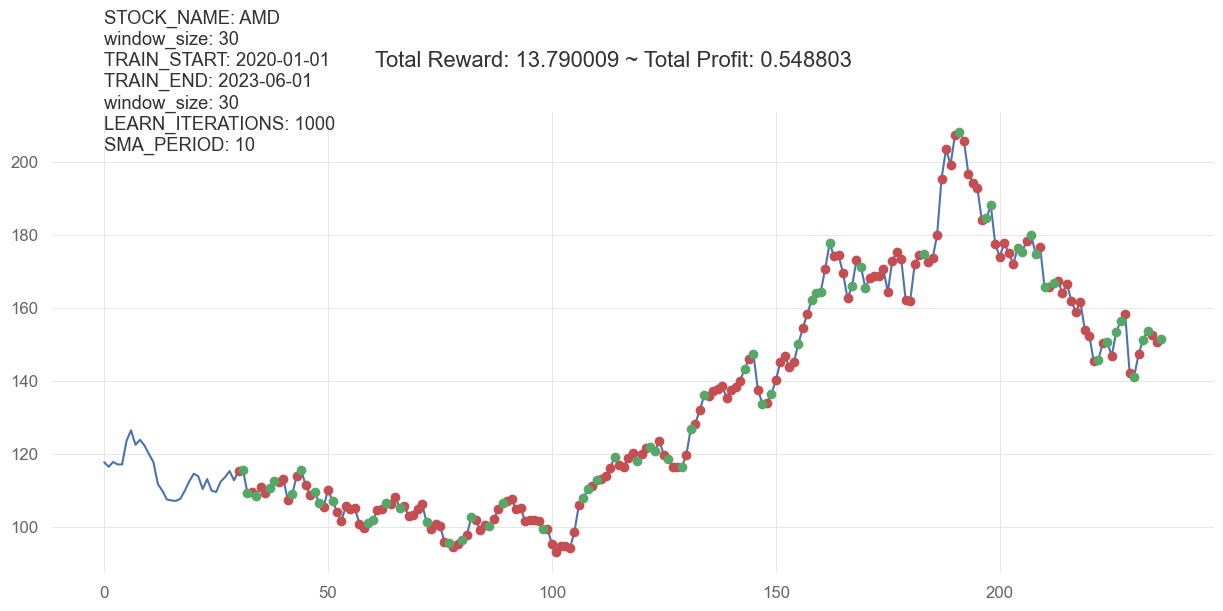

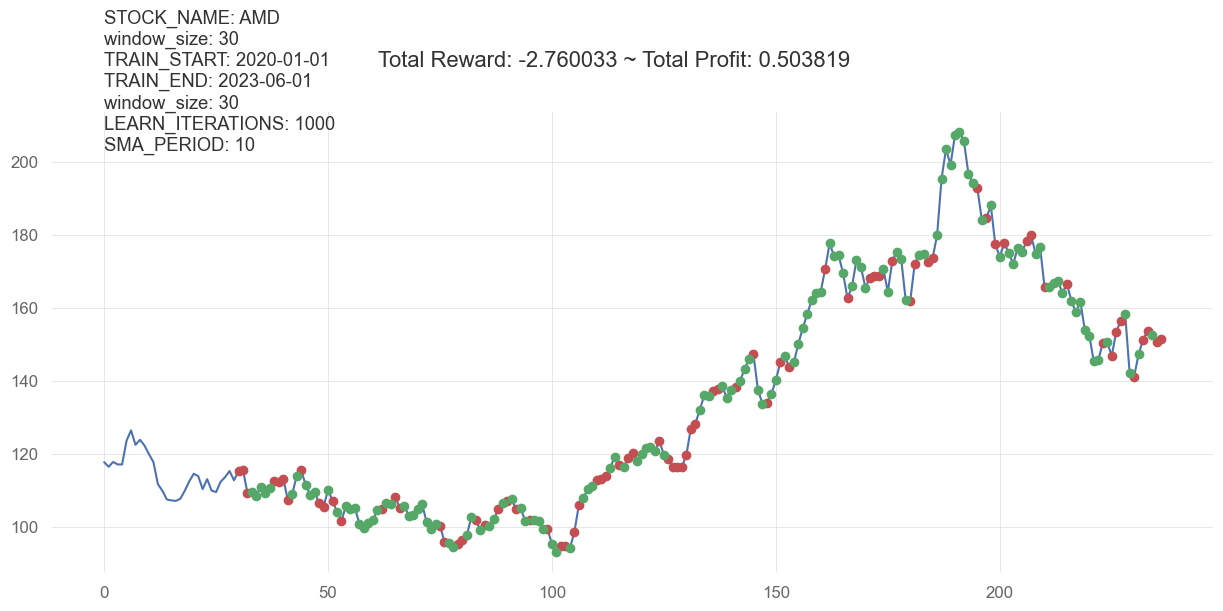

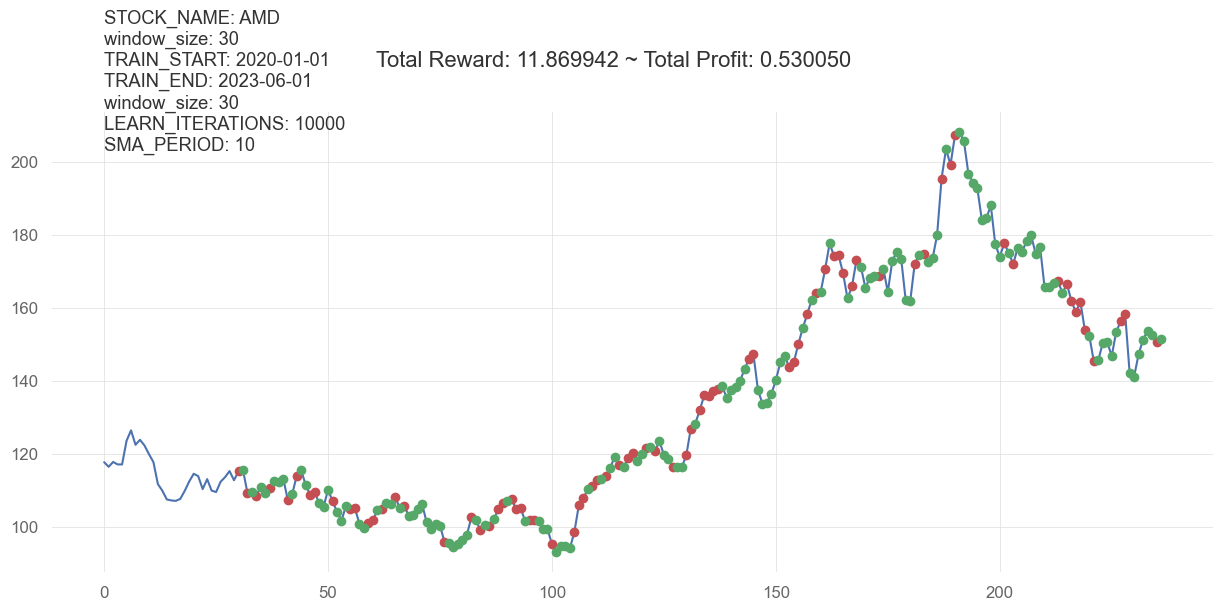

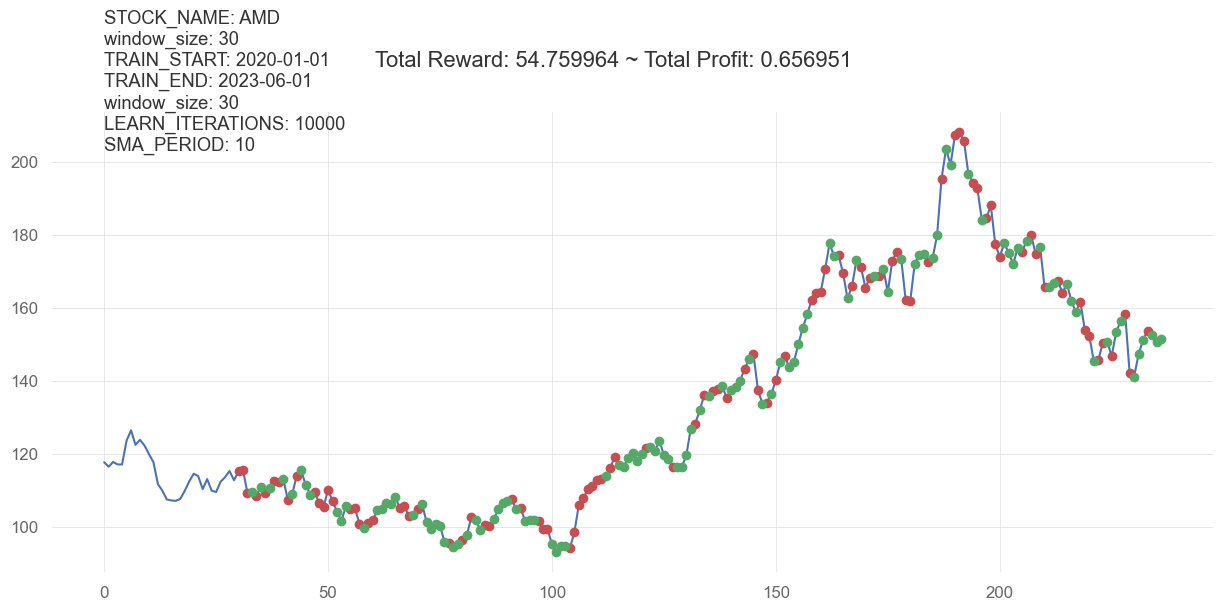

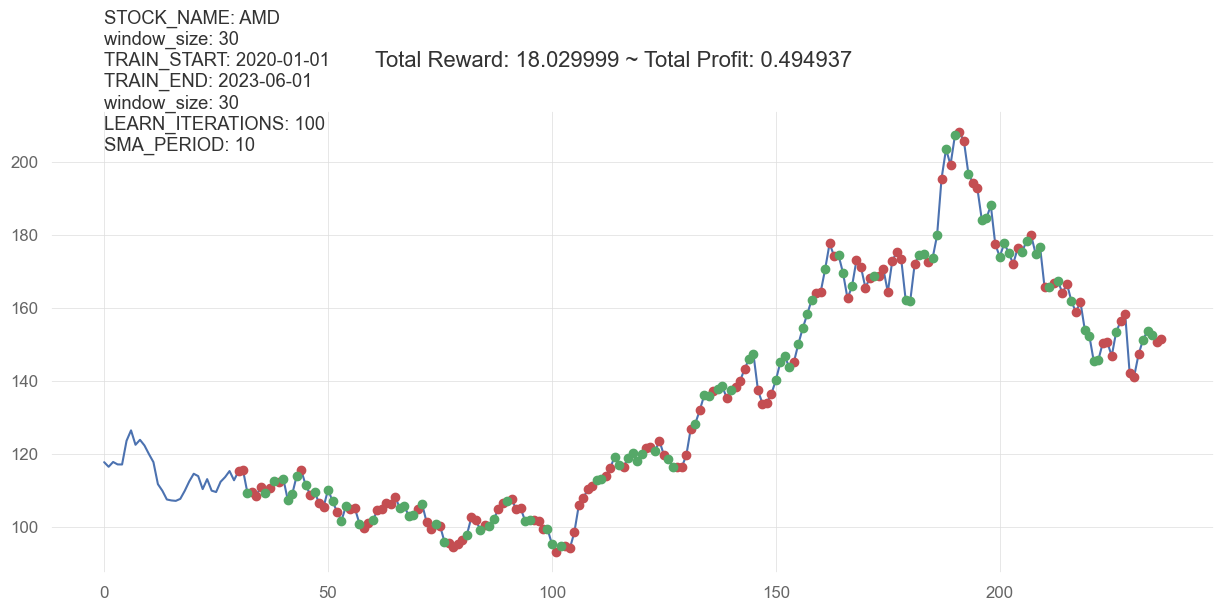

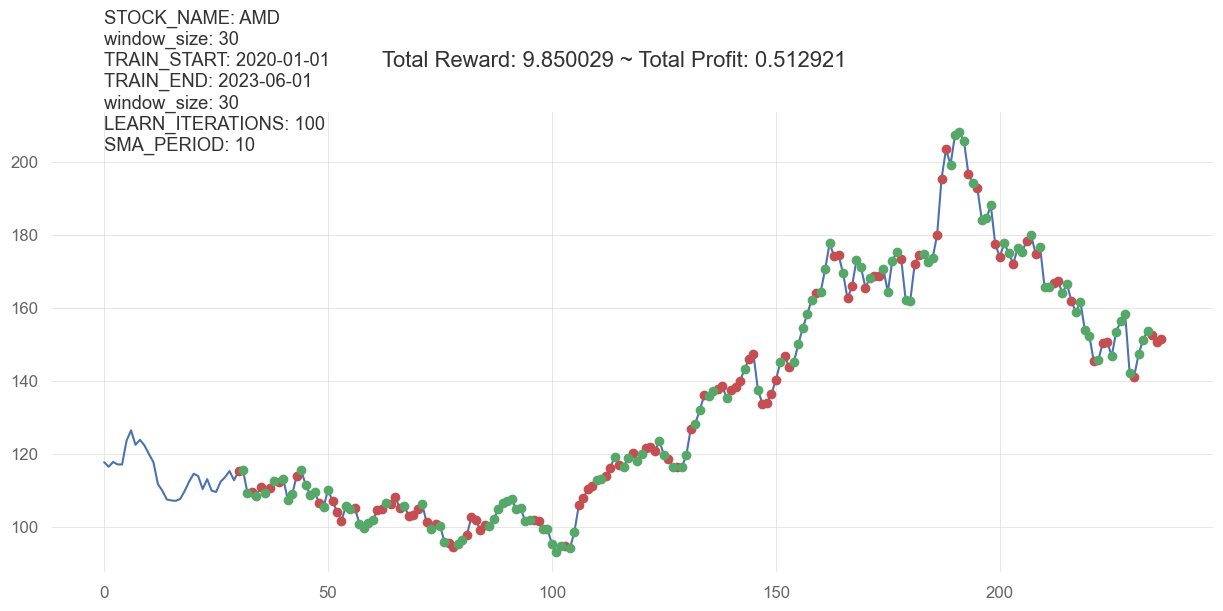

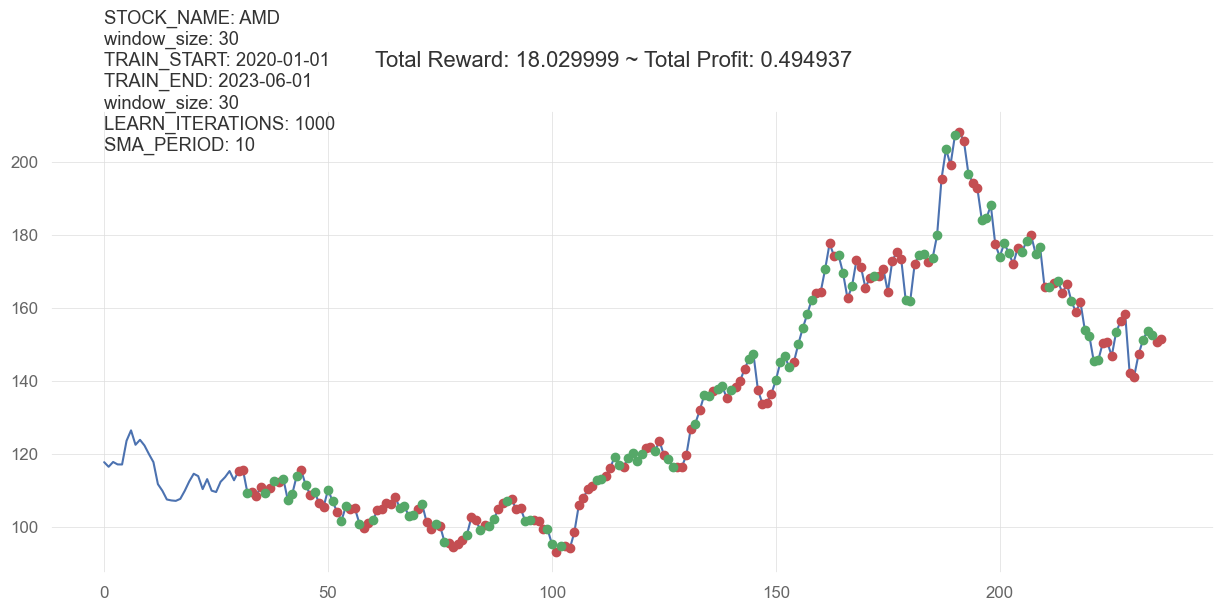

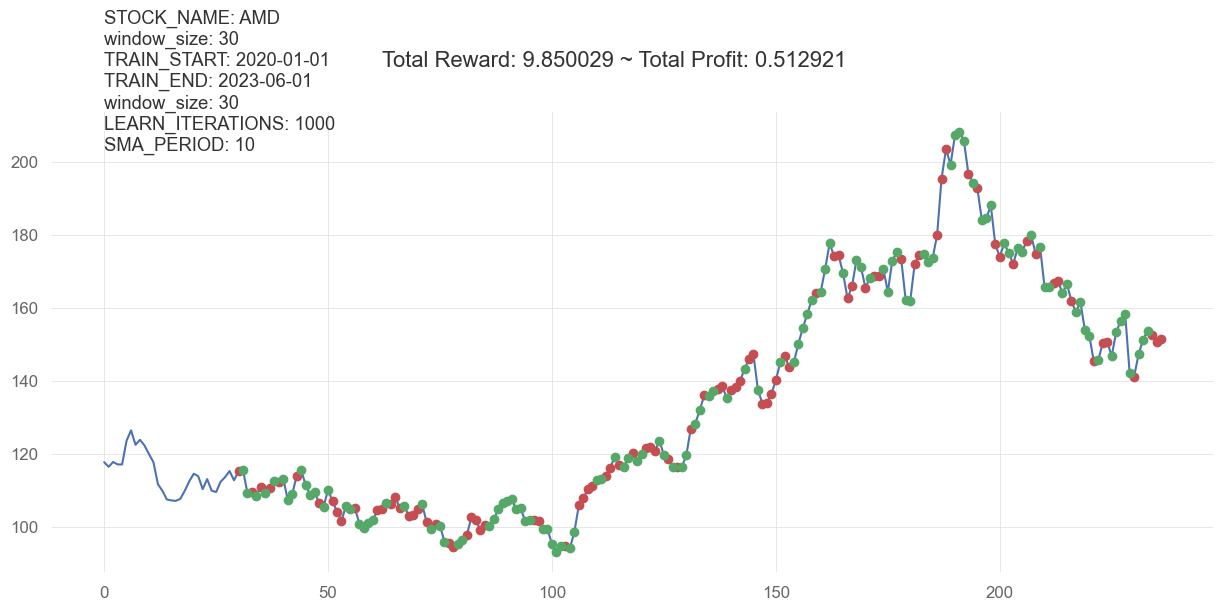

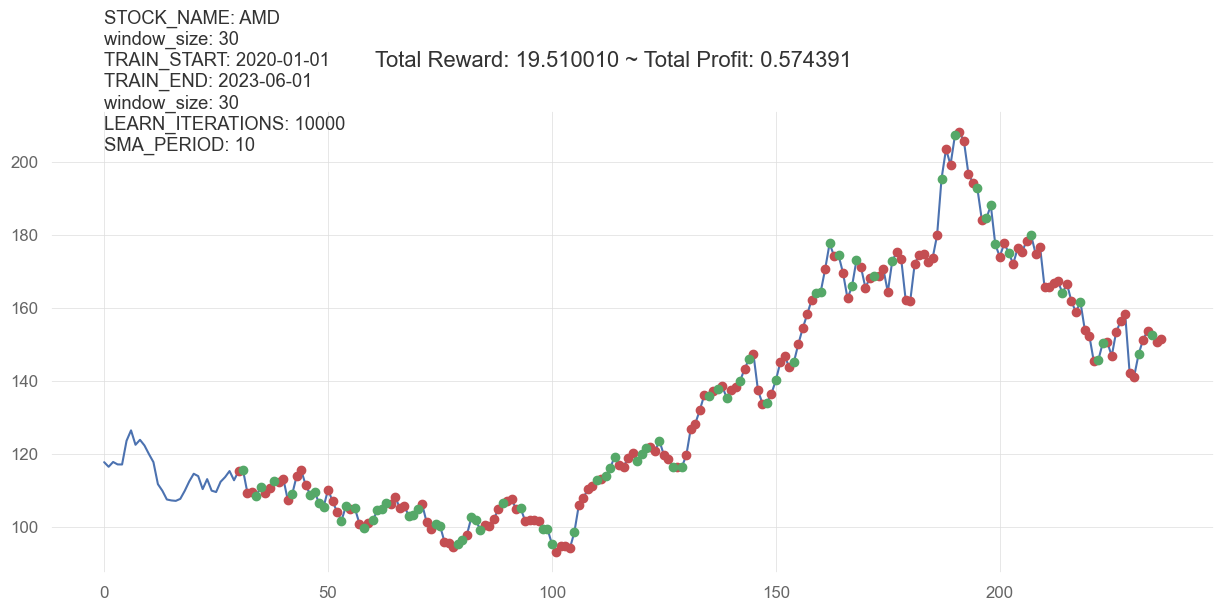

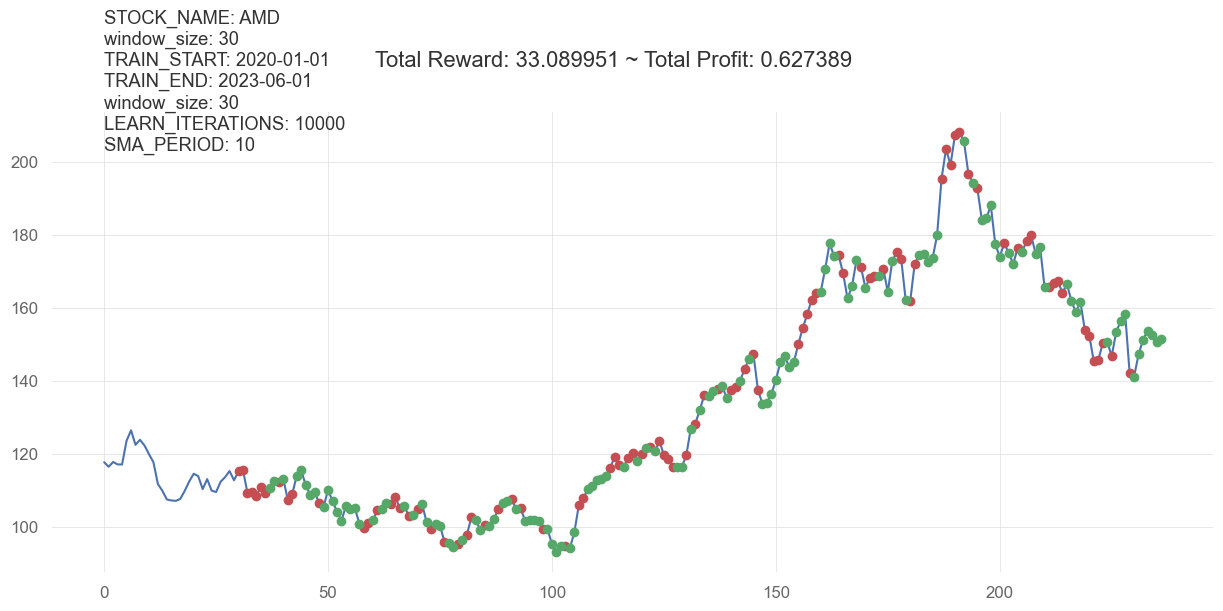

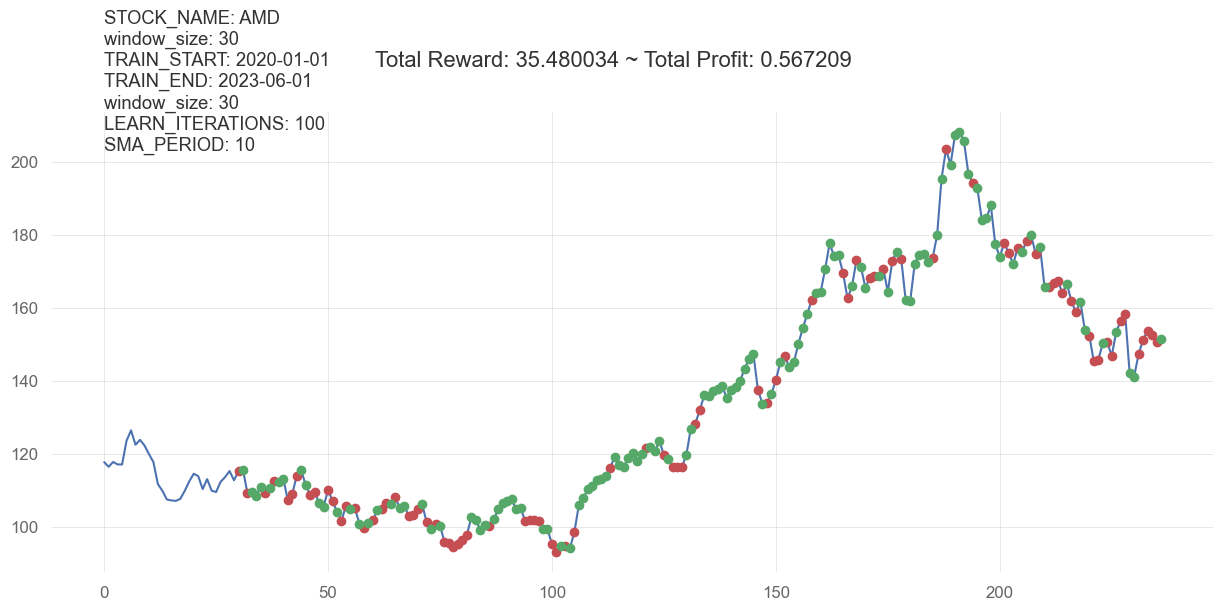

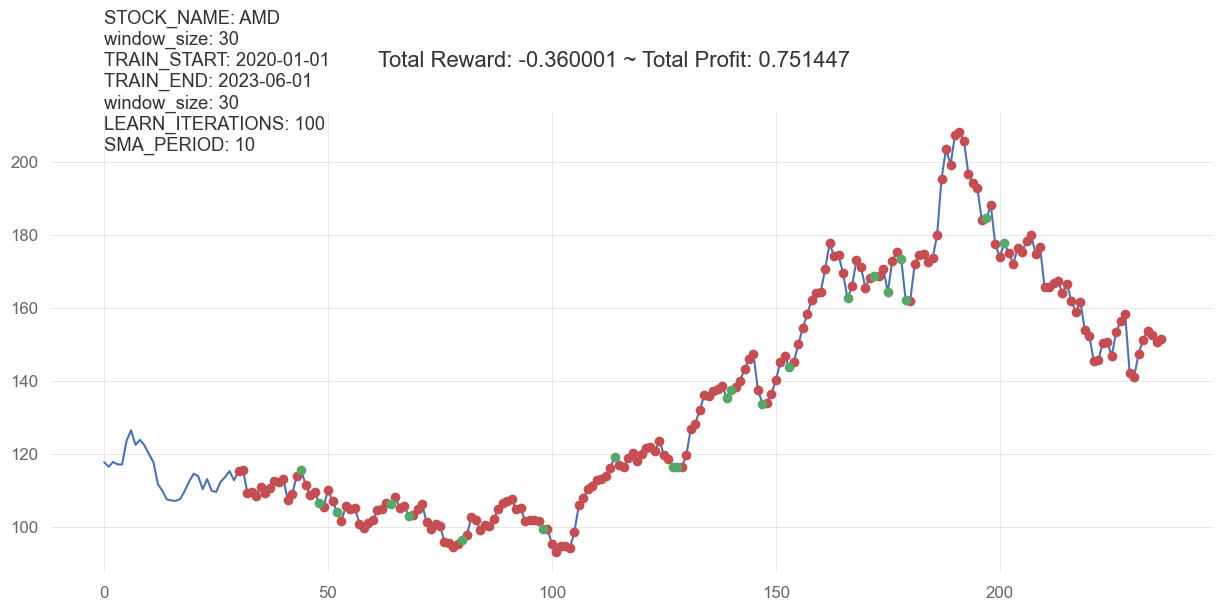

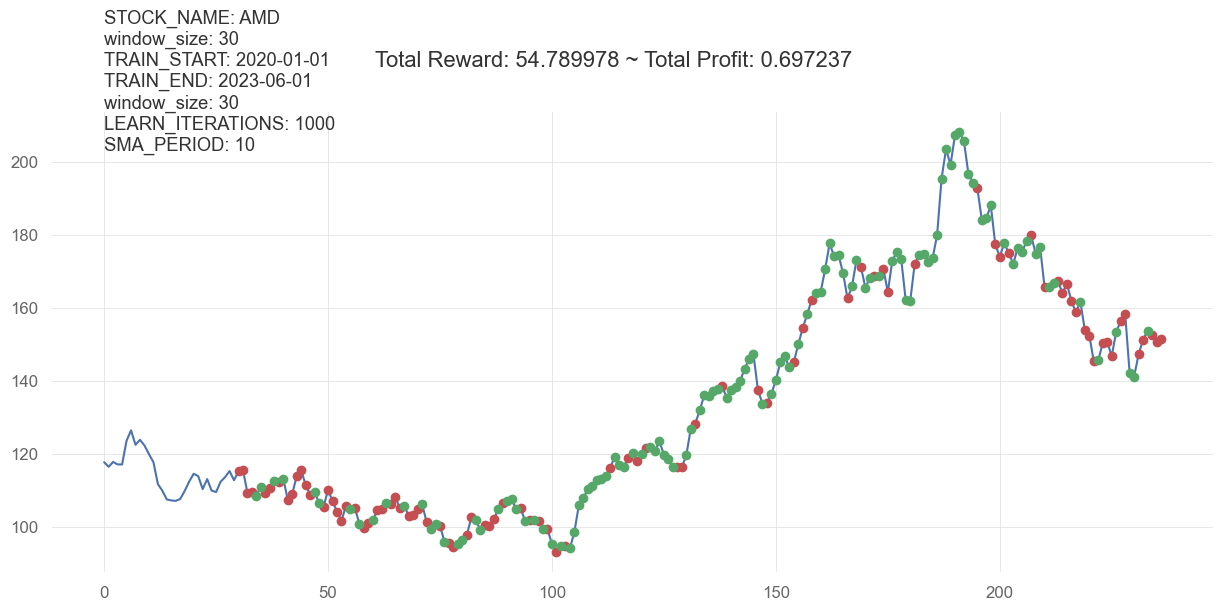

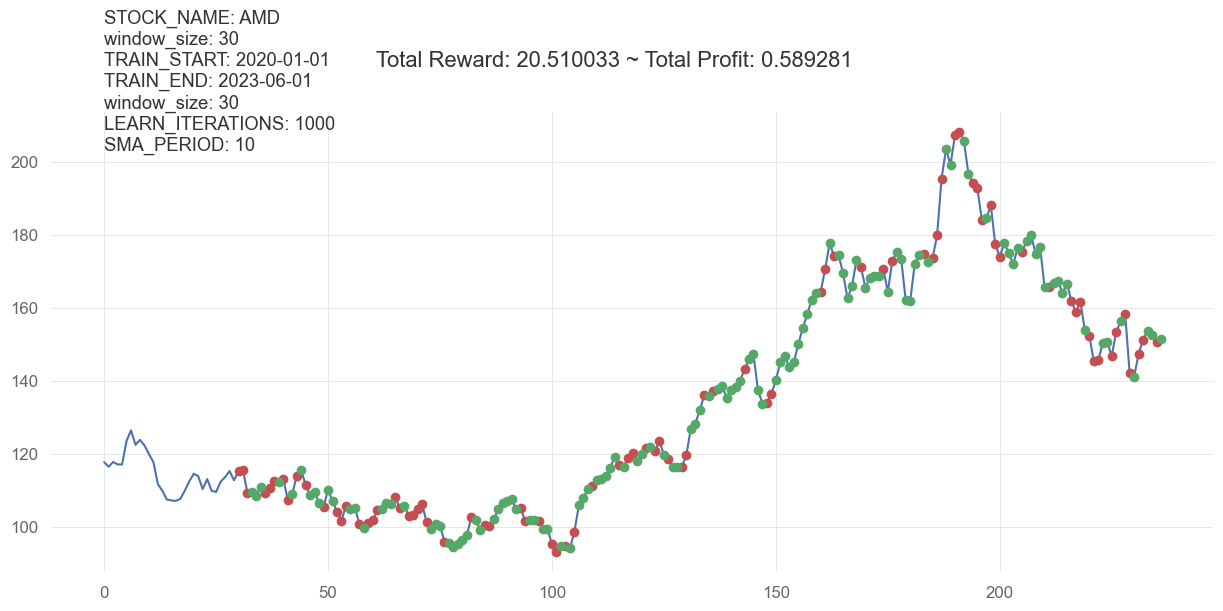

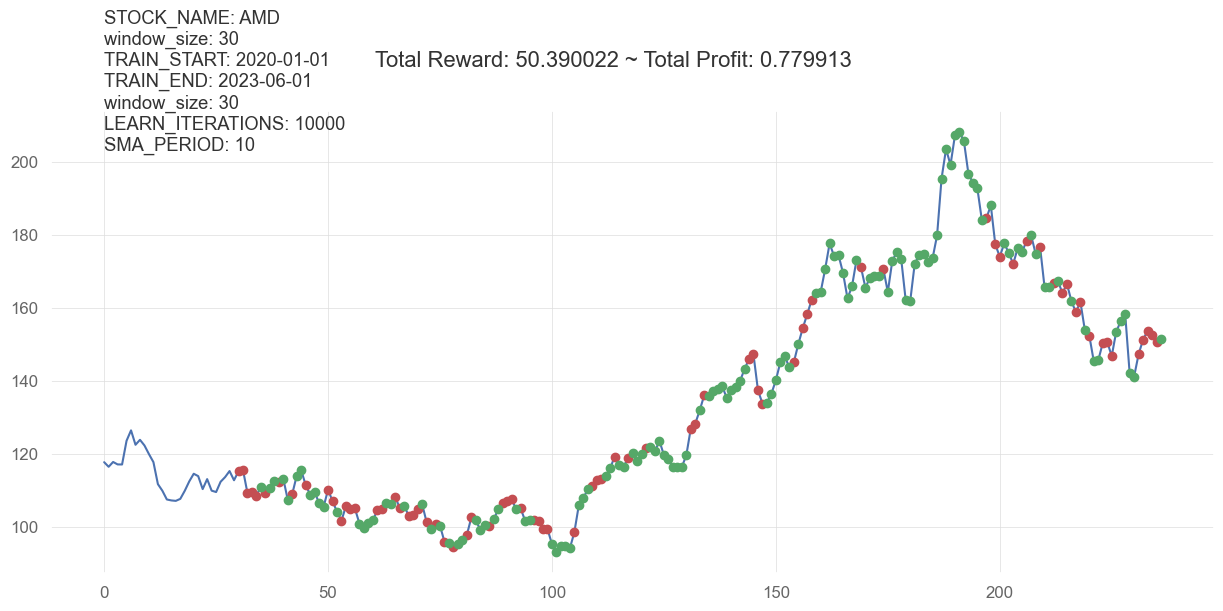

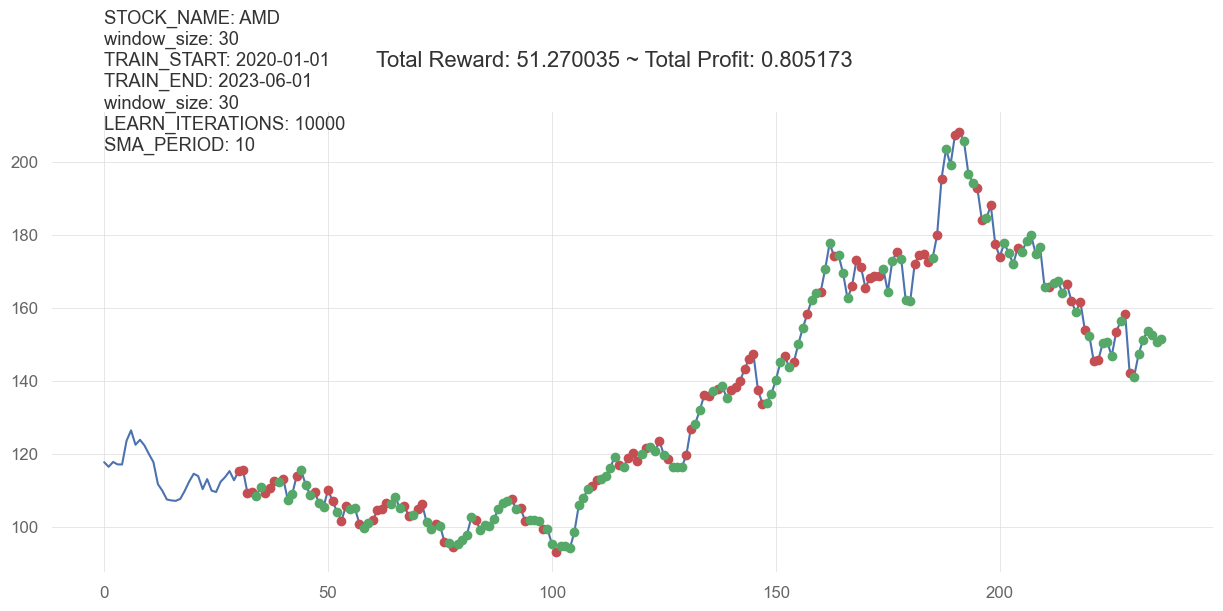

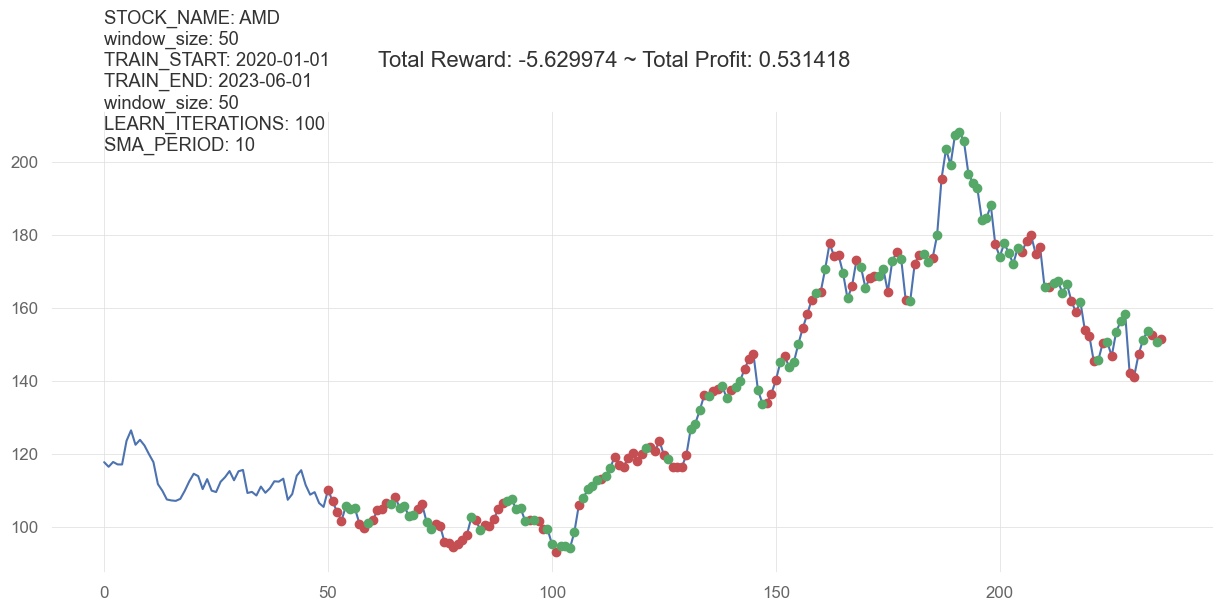

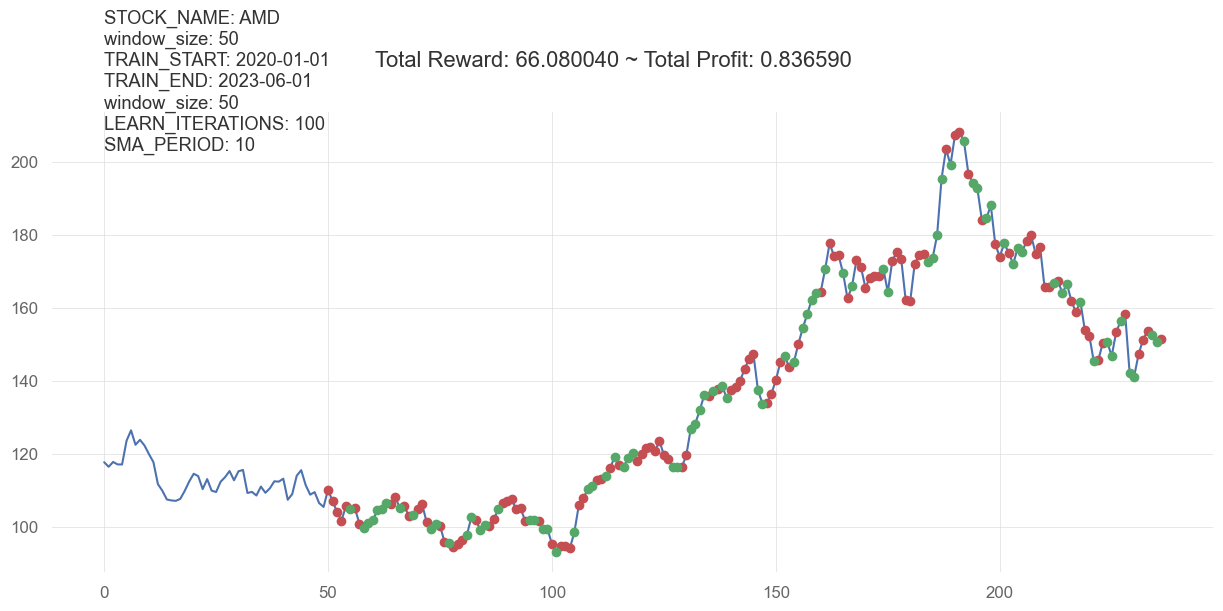

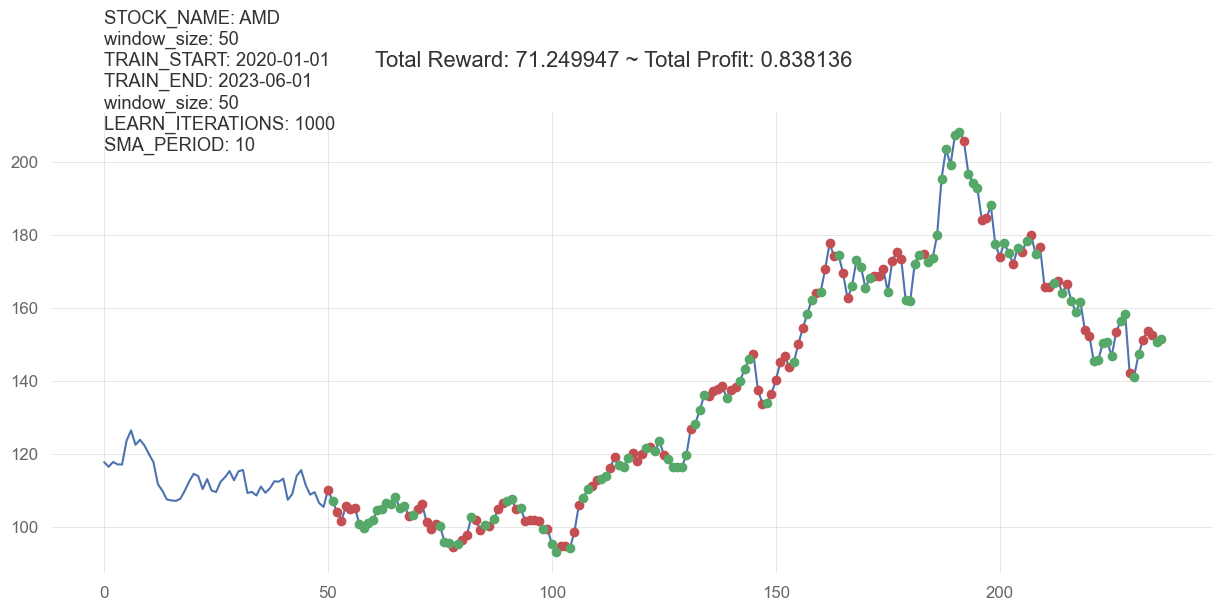

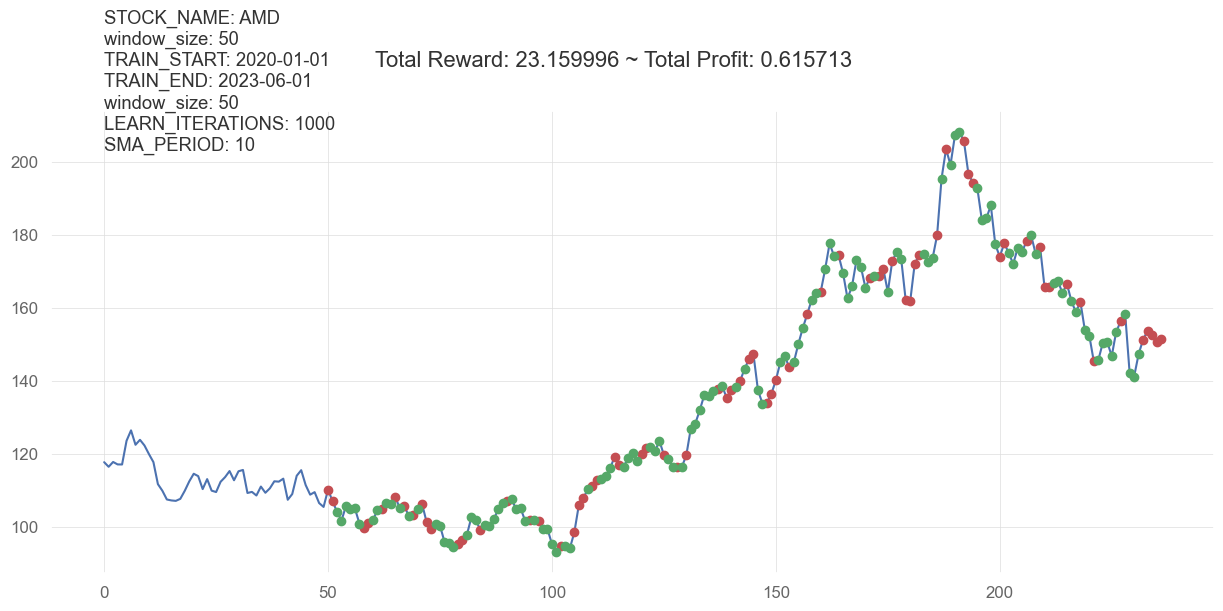

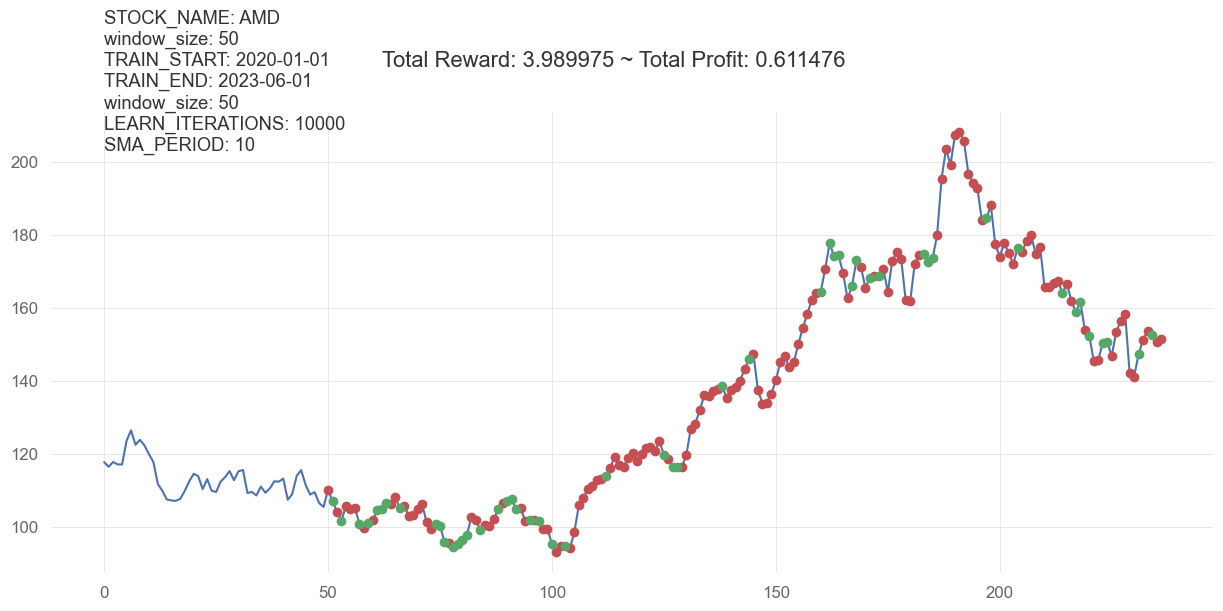

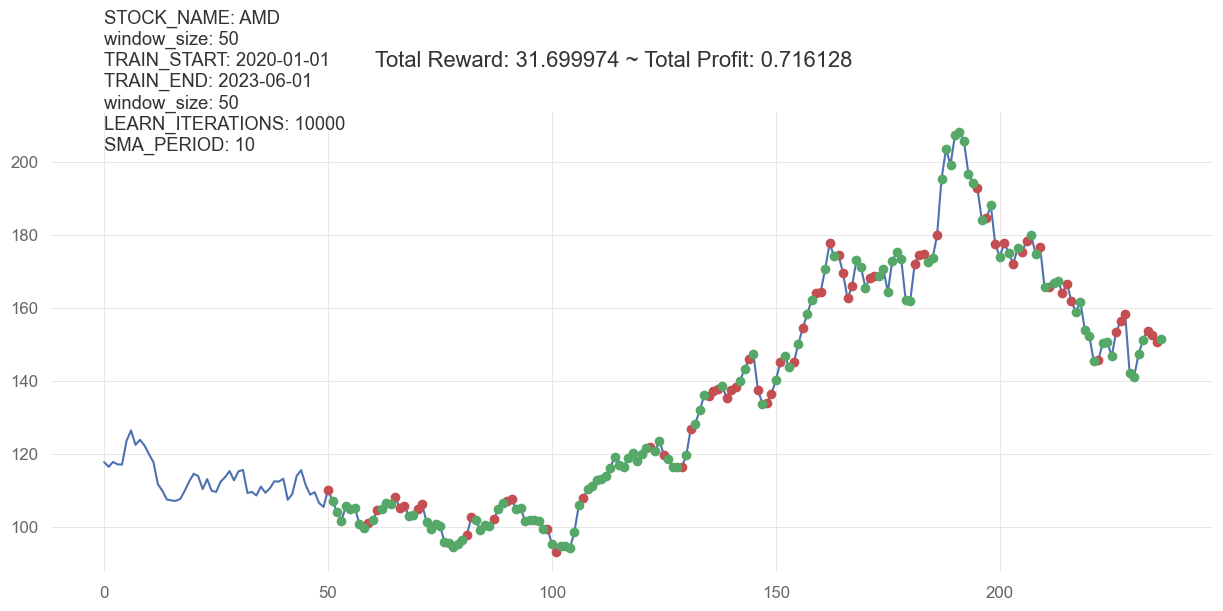

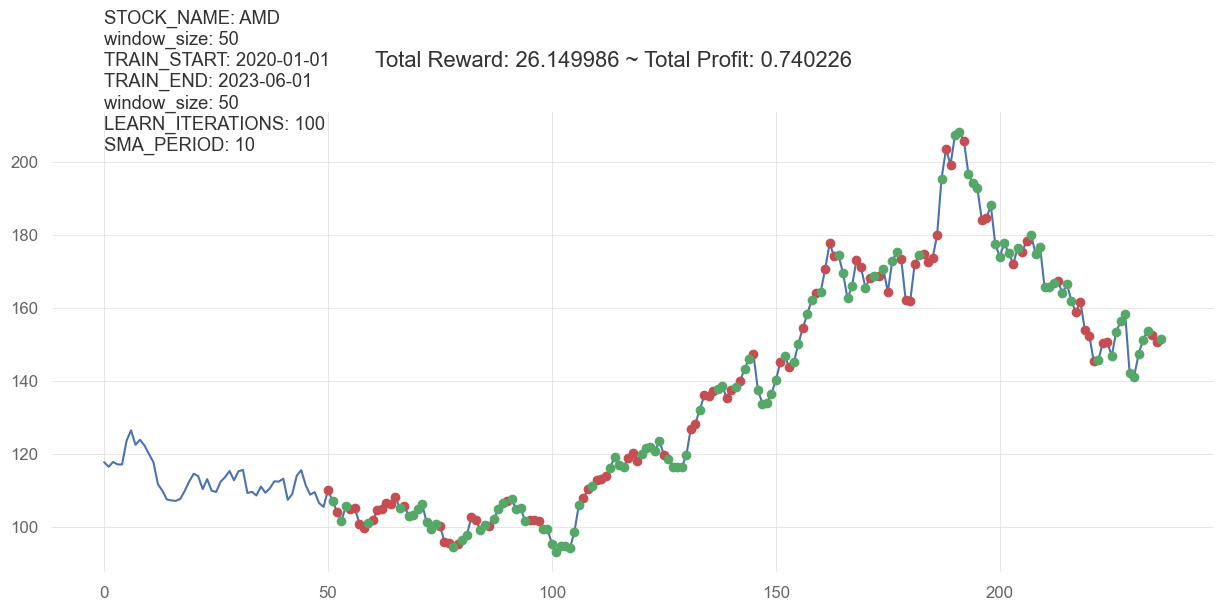

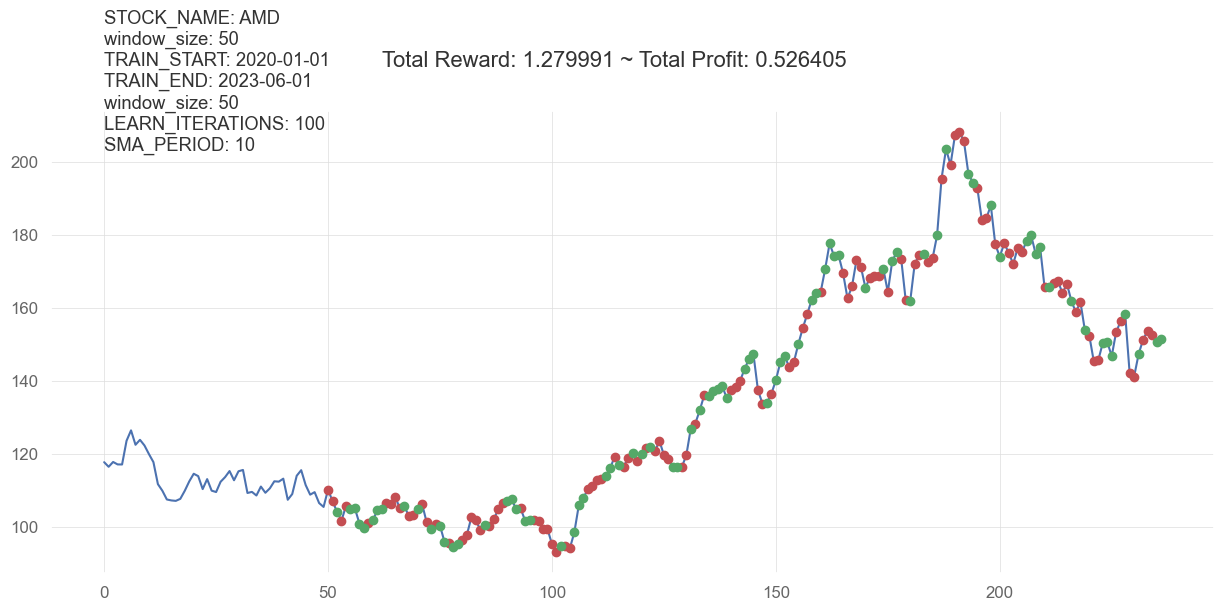

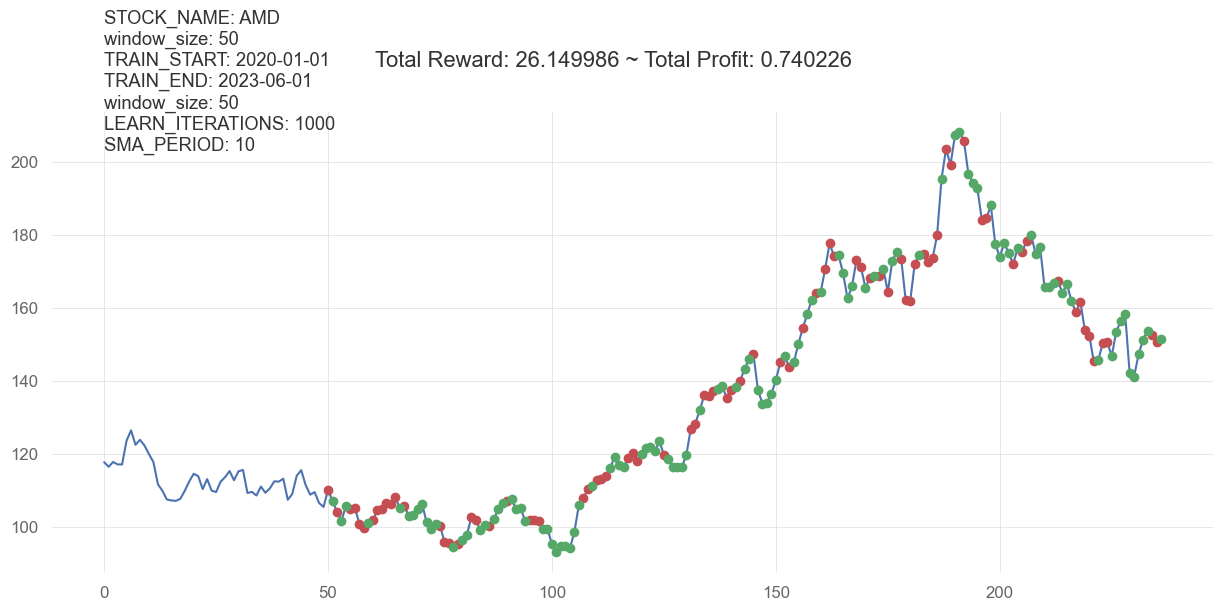

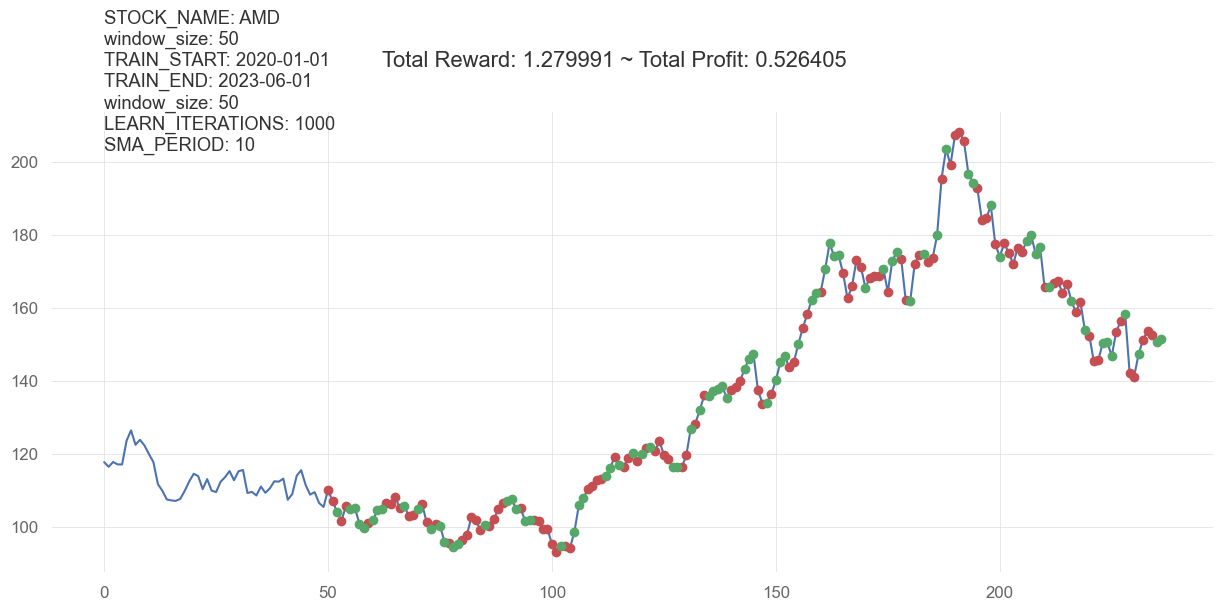

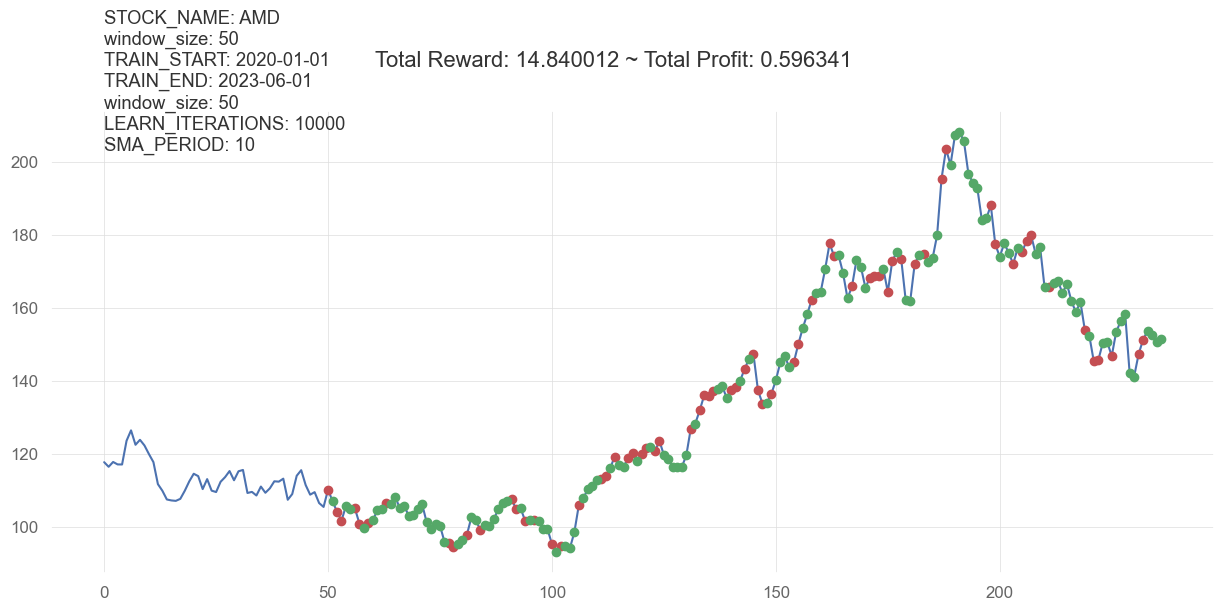

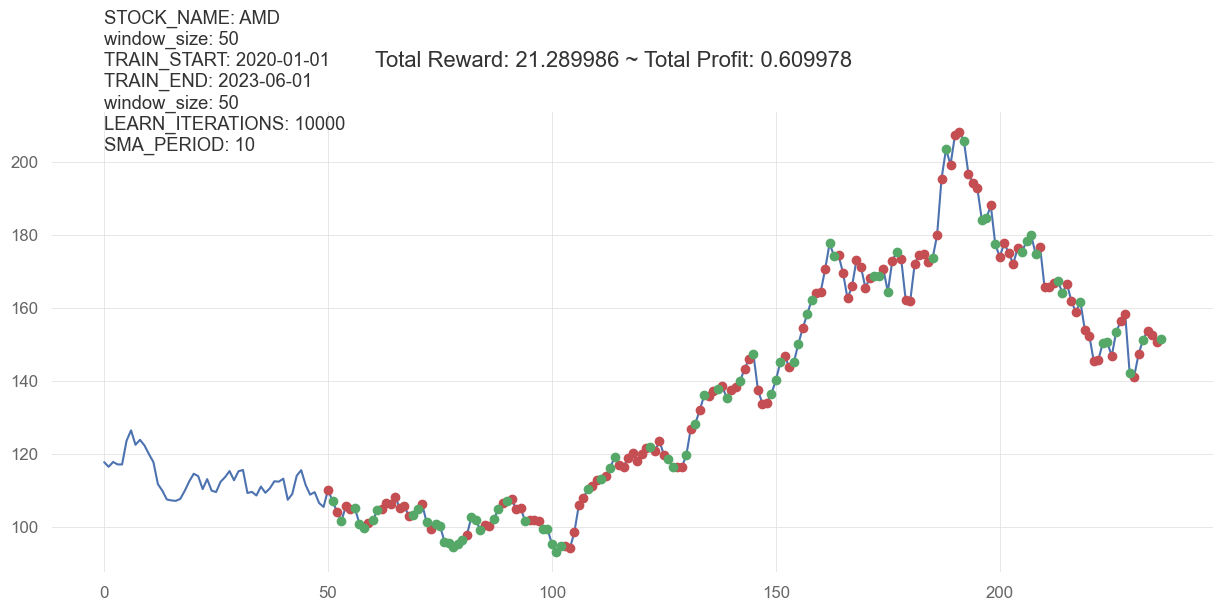

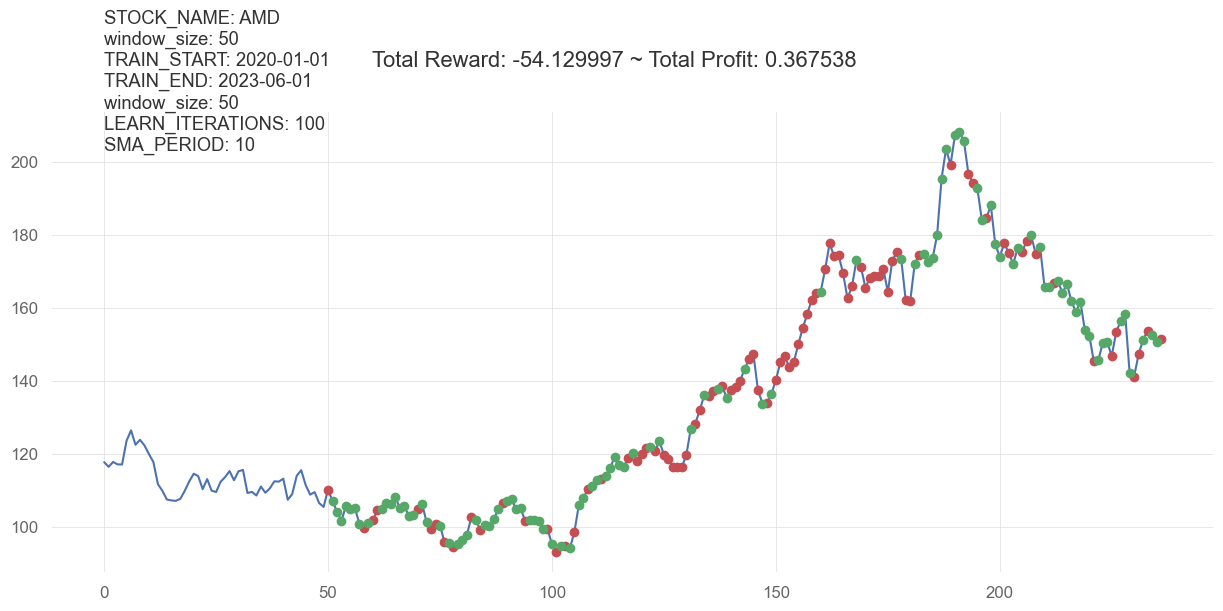

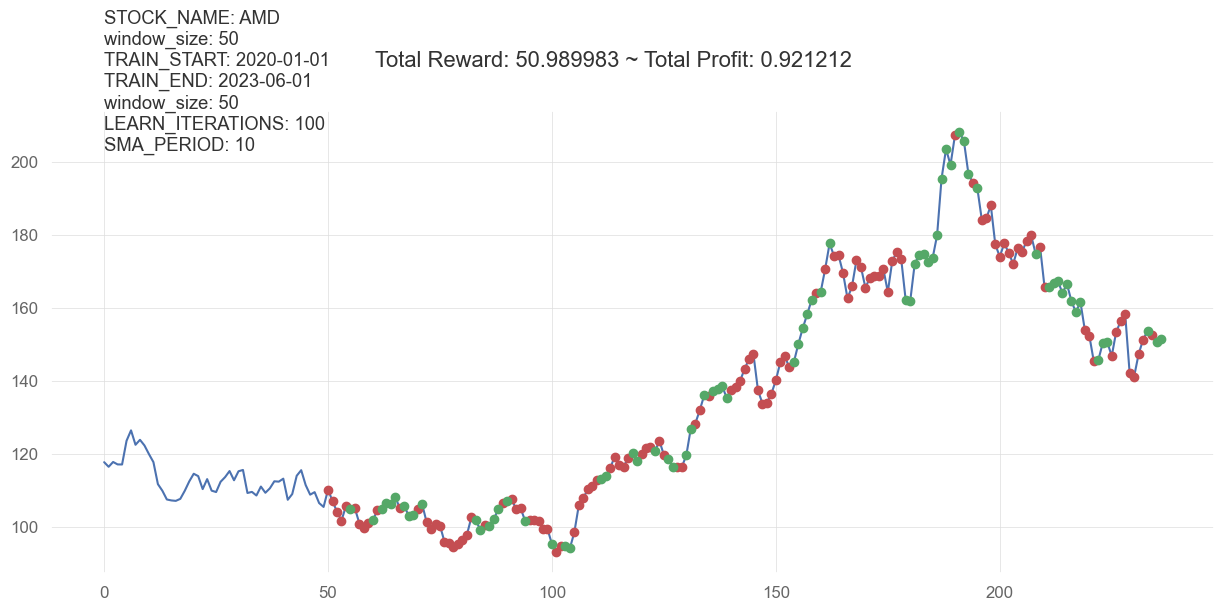

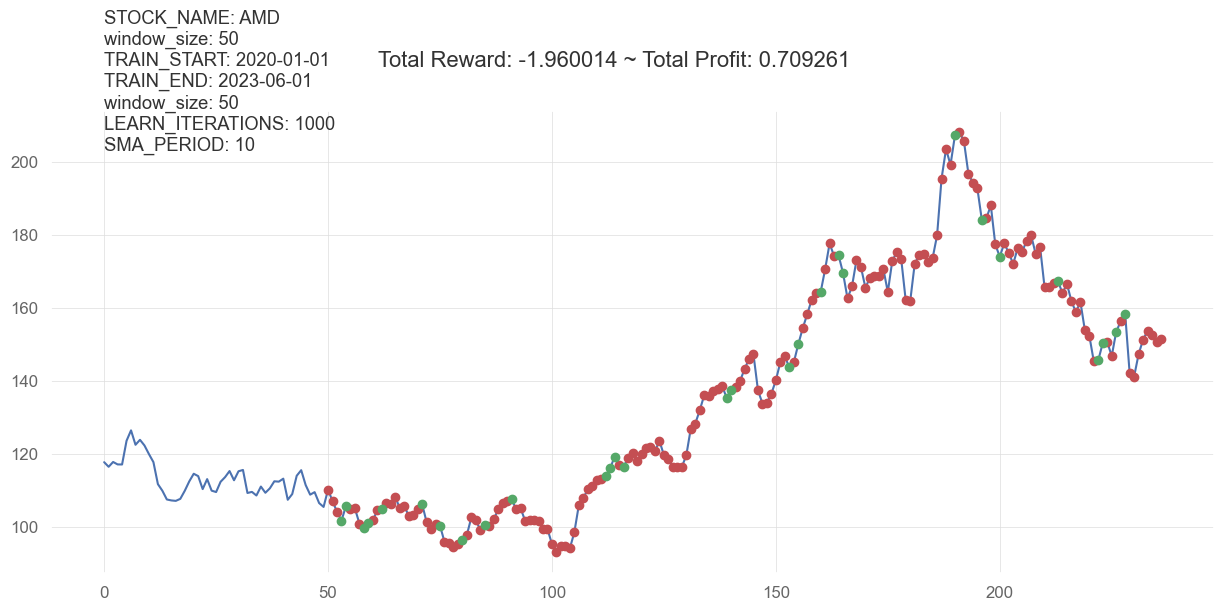

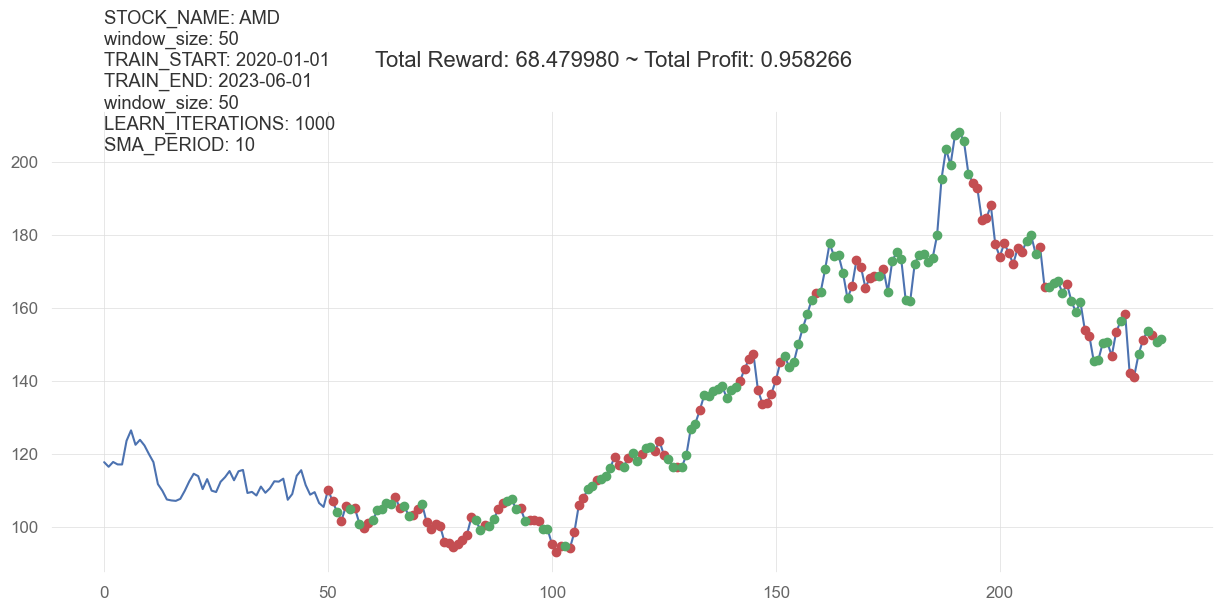

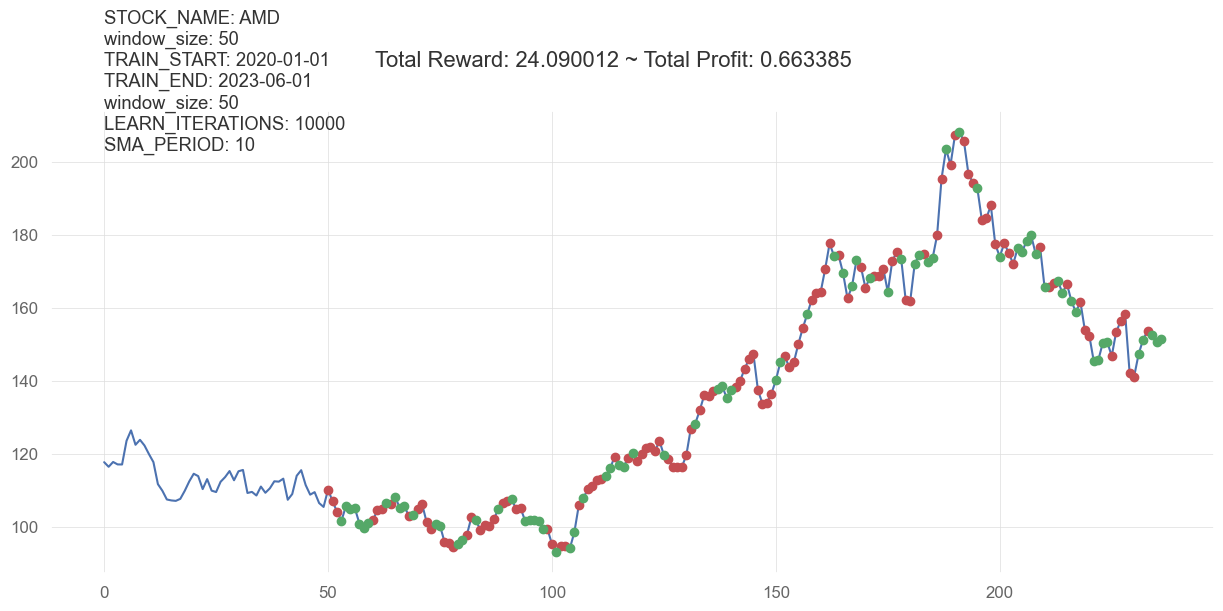

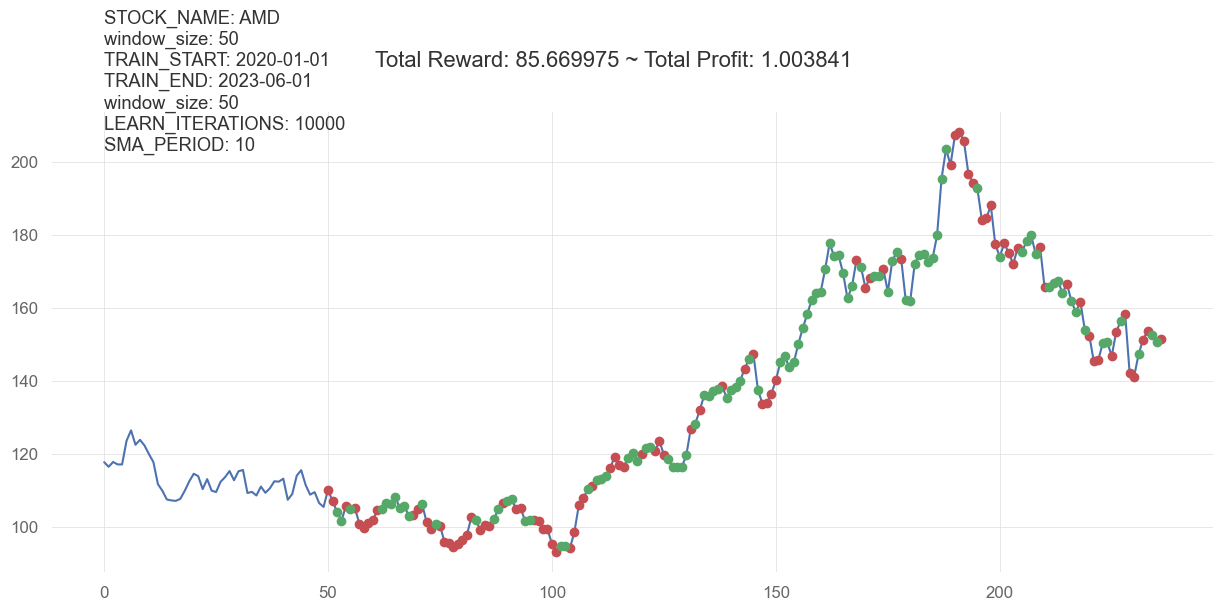

In [107]:
analysis = []
stock_names = ['AMD']
for stock_name in stock_names:
    base_settings = {
        'stock_name': stock_name,
        'train_start': '2020-01-01',
        'train_end': '2023-06-01',
    }

    grid = {
        'window_size': [10, 30, 50],
        'model_name': ['A2C', 'PPO', 'DQN'],
        'learn_iteration': [100, 1000, 10000],
        'add_all': [True, False]
    }

    if not os.path.exists(stock_name):
        os.makedirs(stock_name)

    # Loop over al grid search combinations
    for values in itertools.product(*grid.values()):
        point = dict(zip(grid.keys(), values))

        # merge the general settings
        settings = {**base_settings, **point}
        analysis.append(analyze_stock(**settings))


In [108]:
df_analysis = pd.DataFrame(analysis)
df_analysis

stock_name  window_size train_start   train_end  learn_iteration  \
0         AMD           10  2020-01-01  2023-06-01              100   
1         AMD           10  2020-01-01  2023-06-01              100   
2         AMD           10  2020-01-01  2023-06-01             1000   
3         AMD           10  2020-01-01  2023-06-01             1000   
4         AMD           10  2020-01-01  2023-06-01            10000   
5         AMD           10  2020-01-01  2023-06-01            10000   
6         AMD           10  2020-01-01  2023-06-01              100   
7         AMD           10  2020-01-01  2023-06-01              100   
8         AMD           10  2020-01-01  2023-06-01             1000   
9         AMD           10  2020-01-01  2023-06-01             1000   
10        AMD           10  2020-01-01  2023-06-01            10000   
11        AMD           10  2020-01-01  2023-06-01            10000   
12        AMD           10  2020-01-01  2023-06-01              100   
13        AMD           10  2020-01-01  2023-06-01              100   
14        AMD           10  2020-01-01  2023-06-01             1000   
15        AMD           10  2020-01-01  2023-06-01             1000   
16        AMD           10  2020-01-01  2023-06-01            10000   
17        AMD           10  2020-01-01  2023-06-01            10000   
18        AMD           30  2020-01-01  2023-06-01              100   
19        AMD           30  2020-01-01  2023-06-01              100   
20        AMD           30  2020-01-01  2023-06-01             1000   
21        AMD           30  2020-01-01  2023-06-01             1000   
22        AMD           30  2020-01-01  2023-06-01            10000   
23        AMD           30  2020-01-01  2023-06-01            10000   
24        AMD           30  2020-01-01  2023-06-01              100   
25        AMD           30  2020-01-01  2023-06-01              100   
26        AMD           30  2020-01-01  2023-06-01             1000   
27        AMD           30  2020-01-01  2023-06-01             1000   
28        AMD           30  2020-01-01  2023-06-01            10000   
29        AMD           30  2020-01-01  2023-06-01            10000   
30        AMD           30  2020-01-01  2023-06-01              100   
31        AMD           30  2020-01-01  2023-06-01              100   
32        AMD           30  2020-01-01  2023-06-01             1000   
33        AMD           30  2020-01-01  2023-06-01             1000   
34        AMD           30  2020-01-01  2023-06-01            10000   
35        AMD           30  2020-01-01  2023-06-01            10000   
36        AMD           50  2020-01-01  2023-06-01              100   
37        AMD           50  2020-01-01  2023-06-01              100   
38        AMD           50  2020-01-01  2023-06-01             1000   
39        AMD           50  2020-01-01  2023-06-01             1000   
40        AMD           50  2020-01-01  2023-06-01            10000   
41        AMD           50  2020-01-01  2023-06-01            10000   
42        AMD           50  2020-01-01  2023-06-01              100   
43        AMD           50  2020-01-01  2023-06-01              100   
44        AMD           50  2020-01-01  2023-06-01             1000   
45        AMD           50  2020-01-01  2023-06-01             1000   
46        AMD           50  2020-01-01  2023-06-01            10000   
47        AMD           50  2020-01-01  2023-06-01            10000   
48        AMD           50  2020-01-01  2023-06-01              100   
49        AMD           50  2020-01-01  2023-06-01              100   
50        AMD           50  2020-01-01  2023-06-01             1000   
51        AMD           50  2020-01-01  2023-06-01             1000   
52        AMD           50  2020-01-01  2023-06-01            10000   
53        AMD           50  2020-01-01  2023-06-01            10000   

   model_name  add_all  total_profit  
0         A2C     True          0.45  
1         A2C    Fa

In [109]:
df_analysis.to_csv('amd_analysis_updated.csv', index=False)

In [33]:
from typing import List
SEED = 5756
def analyze_stock(
    stock_name: str,
    window_size: int,
    train_start: str,
    train_end: str,
    learn_iteration: str,
    model_name: str
) -> None:
    df = yf.Ticker(stock_name)
    df = df.history(period="max")
    df = df.loc['2020-01-01':, ['Open', 'High', 'Low', 'Close', 'Volume']]
    TRAIN_ENV_FRAME_BOUND = (window_size, df[train_start:train_end].shape[0])
    TEST_ENV_FRAME_BOUND = (df[train_start:train_end].shape[0] + window_size, df.shape[0])


    df_augmented = df.copy()
    df_augmented['SMA'] = TA.SMA(df_augmented, 10)
    df_augmented['RSI'] = TA.RSI(df_augmented)
    df_augmented['OBV'] = TA.OBV(df_augmented)
    df_augmented.fillna(0, inplace=True)

    def add_signals(env):
        start = env.frame_bound[0] - env.window_size
        end = env.frame_bound[1]
        prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
        signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
        return prices, signal_features
    
    class MyCustomEnv(StocksEnv):
        _process_data = add_signals

    env2 = MyCustomEnv(df=df_augmented, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=window_size)
    env_maker = lambda: env2
    env = DummyVecEnv([env_maker])

    if model_name == 'A2C':
        model = A2C('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'RecurrentPPO':
        model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'PPO':
        model = PPO('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'DQN':
        model = DQN('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)

    env = MyCustomEnv(df=df_augmented, frame_bound=TEST_ENV_FRAME_BOUND, window_size=window_size)
    observation, info = env.reset()
    while True: 
        observation = observation[np.newaxis, ...]
        action, _states = model.predict(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            print("info", info)
            break
    
    total_profit = round(info['total_profit'], 2)

    # Report output
    trade_strategy_output = f".\\{stock_name}\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{window_size}_ITER{learn_iteration}_trade_strategy.png"
    report_output = f".\\{stock_name}\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{window_size}_ITER{learn_iteration}_reports.html"

    desc = f'STOCK_NAME: {stock_name}\nwindow_size: {window_size}\nTRAIN_START: {train_start}\nTRAIN_END: {train_end}\nwindow_size: {window_size}\nLEARN_ITERATIONS: {learn_iteration}\nSMA_PERIOD: 10'
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.text(0, env.prices.max() - 5, desc)
    plt.savefig(trade_strategy_output)

    qs.extend_pandas()

    net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df_augmented.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
    returns = net_worth.pct_change().iloc[1:]

    qs.reports.html(returns, output=report_output)